# Knapsack

## Teoría

### 1. ¿Qué es la Programación Dinámica?

La Programación Dinámica (PD) es una familia de métodos usados para resolver procesos de decisión secuenciales. PD se aplica cuando se conoce completamente el modelo del entorno, es decir:

- Las probabilidades de transición: $P(s' \mid s, a)$
- Las recompensas esperadas: $R(s, a, s')$

El objetivo es encontrar una política que maximice la recompensa acumulada esperada. Esto se hace resolviendo recursivamente las **ecuaciones de Bellman**.

### 2. Componentes

Un problema secuencial se modela como un **Proceso de Decisión de Markov (MDP)** con:

- $S$: conjunto de estados.
- $A$: conjunto de acciones.
- $P(s' \mid s, a)$: probabilidad de transitar a $s'$ desde $s$ al tomar $a$.
- $R(s, a, s')$: recompensa esperada al ir de $s$ a $s'$ con acción $a$.
- $\gamma$: factor de descuento $(0 \leq \gamma \leq 1)$ que pondera recompensas futuras.

### 3. Funciones de Valor

$v_\pi(s)$ es la recompensa esperada al seguir la política $\pi$ desde el estado $s$:

$$
v_\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t R_{t+1} \mid S_0 = s \right]
$$

Ecuación de Bellman para $v_\pi$:

$$
v_\pi(s) = \sum_a \pi(a \mid s) \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma v_\pi(s') \right]
$$

 ### 4. Objetivo: encontrar la política óptima

Queremos encontrar una política $\pi^*$ tal que:

$$
v_{\pi^*}(s) \geq v_\pi(s), \quad \text{para todo } s \text{ y para toda } \pi
$$

La función de valor óptima $v_*$ satisface la **ecuación de Bellman óptima**:

$$
v_*(s) = \max_a \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma v_*(s') \right]
$$

## MinObras

### Contexto

El Ministerio de Transporte (MinTransporte) cuenta con un presupuesto de **100 millones de pesos** para ejecutar obras de infraestructura vial, con el fin de generar desarrollo en el país.

MinTransporte ha compartido con usted el archivo **“Datos.xlsx”**, el cual contiene información sobre:

- **Costo de ejecución** de cada proyecto (en millones de pesos)
- **Número de empleos generados** (en miles)
- **Ubicación geográfica** del proyecto (latitud y longitud)

El objetivo del Ministerio es **maximizar la cantidad total de empleos generados**, respetando el límite presupuestal.

Este problema se modelará como una **variación del problema de la mochila (knapsack)**, donde:
- El **presupuesto** es la capacidad de la mochila,
- Cada **proyecto** representa un ítem,
- El **costo** del proyecto es el peso del ítem,
- La **cantidad de empleos generados** es el valor del ítem.


### Representación Programación Dinámica

| **Símbolo** | **Definición (problema _knapsack_)** | **Comentarios** |
|-------------|--------------------------------------|-----------------|
| **Estados $\mathcal{S}$** | Par ordenado $s=(i,c)$ donde:<br>• $i \in \{0,\dots,n\}$ es el índice del **próximo** objeto por decidir.<br>• $c \in \{0,\dots,W\}$ es la **capacidad restante**. | Esta representación mantiene la información necesaria: cuántos ítems quedan por evaluar y cuánta capacidad nos queda. |
| **Acciones $\mathcal{A}(s)$** | Para $i < n$:<br>• **Tomar** el objeto $i$ (solo si $w_i \le c$).<br>• **Omitir** el objeto $i$.<br>Para $i = n$ no hay acciones (estado terminal). | Con “tomar” avanzamos al siguiente objeto y restamos su peso; con “omitir” solo avanzamos. |
| **Transición $p(s',r \mid s,a)$** | **Determinista**: al elegir acción $a$ desde $(i,c)$:<br>– Si **tomar**: $s' = (i+1,\,c-w_i)$, recompensa $r = v_i$.<br>– Si **omitir**: $s' = (i+1,\,c)$, recompensa $r = 0$. | No hay azar; todos los caminos están completamente determinados. |
| **Recompensa $\mathcal{R}(s,a)$** | Valor inmediato del objeto si se toma; $0$ si se omite. | La **suma total de recompensas** a lo largo del episodio es exactamente el valor acumulado de la mochila. |
| **Factor de descuento $\gamma$** | $\gamma = 1$ | El episodio es finito (máx. $n$ decisiones) y no nos preocupa preferir valor temprano o tardío. |
| **Distribución inicial $p_0(s)$** | Único estado inicial $s_0 = (0,W)$. | Al empezar, contamos con cero objetos seleccionados y la totalidad de la capacidad. |
| **Estados terminales $\mathcal{T}$** | Todos los estados con $i = n$. | Una vez evaluados los $n$ objetos ya no hay más decisiones; el episodio termina. |

In [176]:
class KnapsackEnv:

    """
    Entorno del problema de la mochila 0-1.

    Estado  : tupla (i, c)
              i - índice del siguiente objeto a considerar   (0 … n).
              c - capacidad restante                         (0 … W).

    Acciones: "tomar", "omitir"
              "tomar" es legal solo si pesos[i] <= c.

    Recompensa: valor del objeto cuando se toma, 0 en caso contrario.

    Episodio: exactamente n decisiones → termina cuando i == n.
    """


    # ---------------------------------------------------------------------
    # Inicializar.
    def __init__(self, weights, values, capacity):
        
        assert len(weights) == len(values), "Todo objeto debe tener peso y valor."

        # 1. --- Información del problema:
        self.weights  = list(weights)           # Pesos del los objetos
        self.values   = list(values)            # Valores de los objetos
        self.capacity = int(capacity)           # Capacidad de la mochila
        self.n        = len(self.weights)       # Número de objetos que hay.
        
        # 2. --- Estado actual del problema:
        self.i = None               # Indice del elemento a evaluar
        self.c = None               # Capacidad disponible
        self.total_reward = None    # Retorno total
        
        # 3. --- Todos los posibles estados. 
        self._states = [(i, c) for i in range(self.n + 1) for c in range(self.capacity + 1)]

    # 4. --- El estado se define siempre como pareja: elemento y capacidad restante
    @property
    def state(self):
        return (self.i, self.c)

    
    # ---------------------------------------------------------------------
    # Imprimir.
    def __repr__(self):
        return (f"KnapsackEnv(#_Objetos = {self.n}, Capacidad = {self.capacity}, "f"#_Estados = {len(self._states)})")


    # ---------------------------------------------------------------------
    # Acciones sobre el ambiente. 

    # 1. --- Dado un estado, que acciones puedo hcaer (legales).
    def actions(self, state=None):

        if state is None: state = self.state            # Si no me pasaron un estado, tomo el del ambiente por defecto.
        i, c = state                                    # Sino, toma el objeto:capacidad_restante del estado.

        if i >= self.n: return []                       # Si ya acabe de revisar todos los objetos, no hay acciones.
        
        acts = ["skip"]                                 # Si quedan acciones por revisar, siempre lo puedo saltar.
        if self.weights[i] <= c: acts.append("take")    # Si cabe el la maleta (peso menor a la capacidad restante) añado la acción tomar.
        return acts
    
    # 2. --- Aplicar una acción sobre el estado actual (Función de transisición).
    def step(self, action):

        # Revisamos que no haya trampa con la acción a hacer. (Esto es factibilidad del problema).
        if action not in self.actions():
            raise ValueError(f"Illegal action {action!r} in state {self.state}")
        
        i, c = self.i, self.c               # Si la acción es legal, recuperamos la información del problema.
        
        # Si la acción es tomar: I. La recompensa es su valor, y II. se debe descontar el peso.
        if action == "take":
            reward = self.values[i]
            c -= self.weights[i]
        
        # Si la acción es omitir: I. No hay recompensa y II. no pasa nada con la capacidad.
        else:
            reward = 0
        
        # Siempre avanzo al siguiente objeto, con la capacidad del morral actualizada (capacidad restante).
        i += 1
        self.i, self.c = i, c
        
        # Calculo la utilidad total y reviso si ya acabe.
        self.total_reward += reward
        done = (i == self.n)

        return self.state, reward, done
    
    # 3. --- Simular una acción sobre el un estado dado (Función de transisición).
    def sim_step(self, state, action):

        # Recuperamos la información del problema.
        i, c = state

        # Si la acción es tomar: I. La recompensa es su valor, y II. se debe descontar el peso.
        if action == "take":
            reward = self.values[i]
            c -= self.weights[i]

        # Si la acción es omitir: I. No hay recompensa y II. no pasa nada con la capacidad.
        else:
            reward = 0
        
        # Siempre avanzo al siguiente objeto, con la capacidad del morral actualizada (capacidad restante).
        return (i + 1, c), reward


    # ---------------------------------------------------------------------
    # Reiniciar
    def reset(self):

        self.i = 0                  # Empezamos en el objeto 0
        self.c = self.capacity      # Reiniciamos la capacidad al máximo.
        self.total_reward = 0       # Y el total de la recompensa es 0.
        
        return self.state

    
    # ---------------------------------------------------------------------
    # Información

    # 1. -- Si estamos en un estado terminal / final.
    def is_terminal(self, state=None):
        if state is None: state = self.state
        return state[0] >= self.n
    
    # 2. -- Devuelve el espacio de busqueda.
    def state_space(self):
        return self._states

## Métodos de Solución

### Policy Evaluation


Input $\pi$, la política a evaluar  
Inicializar un arreglo $V(s)=0$, para todo $s\in\mathcal{S}^+$  

**Repetir**  
&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow 0$  
&nbsp;&nbsp;&nbsp;&nbsp;**Para cada** $s\in\mathcal{S}$:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$v \leftarrow V(s)$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V(s) \leftarrow \displaystyle\sum_a \pi(a\mid s)\sum_{s',\,r} p(s',r \mid s,a)\,[\,r + \gamma\,V(s')\,]$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow \max\!\bigl(\Delta,\;\lvert v - V(s)\rvert\bigr)$  

**Hasta que** $\Delta < \theta$ (un número pequeño y positivo)  

**Salida** $V \approx v_\pi$

In [177]:
def policy_evaluation(env, policy, gamma: float = 1.0, theta: float = 1e-6, report: bool = False):
    """
    ============================================================================
    Evaluación de una política  (determinista, entorno determinista)
    ─────────────────────────────────────────────────────────────────────────────
    Entradas
      • env      : entorno que implementa
                     ▸ state_space()         → Iterable[State]
                     ▸ is_terminal(s)        → bool
                     ▸ sim_step(s, a)        → (s', r)
      • policy   : dict[State, Action] — política determinista (π(a|s)=𝟙{a=policy[s]})
      • gamma    : factor de descuento γ ∈ (0,1]
      • theta    : umbral de convergencia
      • report   : si es True, muestra trazas de cada iteración

    Salida
      • policy   : se devuelve la misma política recibida (conveniencia)
      • V        : dict[State, float] — aproximación de v_π
    ============================================================================

    Notas
    -----
    * La función **no** modifica la política; simplemente la re-expone para que
      quien la llame pueda encadenar `policy, V = policy_evaluation(...)`
      sin perder la referencia.
    """
    # 1. Inicializar V(s)=0 para todos los estados
    V   = {s: 0.0 for s in env.state_space()}
    cnt = 1  # contador de iteraciones (solo para ‘report’)

    # 2. Iterar hasta la convergencia (Δ < θ)
    while True:

        if report:
            print(f"\nIteración {cnt}")

        delta = 0.0  # Δ ← 0

        # 2.a Recorremos cada estado s ∈ 𝒮
        for s in env.state_space():
            if env.is_terminal(s):          # omitimos terminales
                continue

            v      = V[s]                   # valor anterior
            a      = policy[s]              # acción dictada por π
            next_s, r = env.sim_step(s, a)  # transición única (determinista)

            # Bellman: v(s) ← r + γ·V(s')
            new_v = r + gamma * V[next_s]
            V[s]  = new_v

            # Actualizamos el máximo cambio Δ
            delta = max(delta, abs(v - new_v))

            if report and v != new_v:
                print(f"  s:{s} ─a:{a}→ s':{next_s} | "
                      f"r={r:+.3f}, γV(s')={gamma*V[next_s]:+.3f} → V(s)={new_v:+.3f}")

        if delta < theta:                   # criterio de parada
            break

        cnt += 1

    # 3. Devolver el valor estimado
    return V


### Policy Iteration


1. **Inicialización**  
   $V(s)\in\mathbb{R}$ y $\pi(s)\in\mathcal{A}(s)$ arbitrarios, $\forall\,s\in\mathcal{S}$  

2. **Evaluación de la política**  
   **Repetir**  
   &nbsp;&nbsp;$\Delta \leftarrow 0$  
   &nbsp;&nbsp;**Para cada** $s\in\mathcal{S}$:  
   &nbsp;&nbsp;&nbsp;&nbsp;$v \leftarrow V(s)$  
   &nbsp;&nbsp;&nbsp;&nbsp;$V(s) \leftarrow \displaystyle\sum_{s',\,r} p(s',r \mid s,\pi(s))\,[\,r + \gamma\,V(s')\,]$  
   &nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow \max\!\bigl(\Delta,\;|v - V(s)|\bigr)$  
   **Hasta que** $\Delta < \theta$ (un número pequeño y positivo)  

3. **Mejora de la política**  
   $policy\text{-}stable \leftarrow \text{true}$  
   **Para cada** $s\in\mathcal{S}$:  
   &nbsp;&nbsp;$a \leftarrow \pi(s)$  
   &nbsp;&nbsp;$\displaystyle\pi(s) \leftarrow \arg\max_a \sum_{s',\,r} p(s',r \mid s,a)\,[\,r + \gamma\,V(s')\,]$  
   &nbsp;&nbsp;**Si** $a \ne \pi(s)$ **entonces** $policy\text{-}stable \leftarrow \text{false}$  
   **Si** $policy\text{-}stable$ **entonces** detener y devolver $V$ y $\pi$; **de lo contrario** volver al paso 2

In [178]:
def policy_iteration(env, policy, gamma: float = 1.0, theta: float = 1e-8, report: bool = False):
    """
    ============================================================================
    Algoritmo : Iteración de Políticas (versión determinista, in-place)
    ─────────────────────────────────────────────────────────────────────────────
    Entradas
      • env      : entorno que implementa
                     ▸ state_space()            → Iterable[State]
                     ▸ is_terminal(s)           → bool
                     ▸ sim_step(s, a)           → (s', r)
                     ▸ actions(s)               → Iterable[Action]
      • policy   : dict[State, Action] — política inicial (determinista)
      • gamma    : factor de descuento γ ∈ (0,1]
      • theta    : precisión usada en policy_evaluation
      • report   : pasa la señal a policy_evaluation para trazas

    Salida
      • policy   : política óptima π*
      • V        : valor óptimo V* asociado a π*
    ============================================================================

    Descripción resumida
    ---------------------------------------------------------------------------
      1.  Evalúa la política actual        →  V ← v_π          (policy_evaluation)
      2.  Mejora la política usando V      →  π ← greedy(V)
      3.  Si la política no cambió en ningún estado ⇒ convergencia
          de lo contrario, repetir desde 1
    """

    # -------------------------------------------------------------------------
    #  Bucle principal: repetir hasta que la política se vuelva estable
    # -------------------------------------------------------------------------
    while True:

        # 1. EVALUACIÓN DE LA POLÍTICA  (paso de predicción)
        #    Calcula V ← v_π hasta |Δ|<θ
        V = policy_evaluation(env, policy, gamma, theta, report)

        # 2. MEJORA DE LA POLÍTICA  (paso de control)
        policy_stable = True

        for s in env.state_space():

            if env.is_terminal(s):          # omitimos estados terminales
                continue

            old_a = policy[s]               # acción previa de la política

            # ── 2.a Buscar la acción greedy respecto a V(s)
            best_q = -float('inf')
            best_a = None

            for a in env.actions(s):
                next_s, r = env.sim_step(s, a)          # transición determinista
                q_sa = r + gamma * V[next_s]            # Qπ(s,a) = r + γ V(s')

                if q_sa > best_q:                       # maximizar Qπ(s,a)
                    best_q, best_a = q_sa, a

            # ── 2.b Actualizar π(s) ← argmax_a Qπ(s,a)
            policy[s] = best_a

            # ── 2.c Comprobar si cambió la acción
            if best_a != old_a:
                policy_stable = False

        # 3. CRITERIO DE PARADA: π no cambió en ningún estado
        if policy_stable:
            return policy, V


### Value Iteration

Inicializar el arreglo $V$ de forma arbitraria (p. ej. $V(s)=0$ para todo $s\in\mathcal{S}^+$)  

**Repetir**  
&nbsp;&nbsp;$\Delta \leftarrow 0$  
&nbsp;&nbsp;**Para cada** $s\in\mathcal{S}$:  
&nbsp;&nbsp;&nbsp;&nbsp;$v \leftarrow V(s)$  
&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle V(s) \leftarrow \max_a \sum_{s',\,r} p(s',r \mid s,a)\,[\,r + \gamma\,V(s')\,]$  
&nbsp;&nbsp;&nbsp;&nbsp;$\Delta \leftarrow \max\!\bigl(\Delta,\;|\,v - V(s)\,|\bigr)$  
**Hasta que** $\Delta < \theta$ (un número pequeño y positivo)  

**Salida** una política determinista $\pi$ tal que  
$\displaystyle \pi(s) = \arg\max_a \sum_{s',\,r} p(s',r \mid s,a)\,[\,r + \gamma\,V(s')\,]$


In [179]:
def value_iteration(env, gamma=1.0, theta=1e-8):
    """
    Iteración de valores para control óptimo (algoritmo de la figura “Value Iteration”).
    
    1. **Inicializar** V(s) arbitrariamente (aquí 0) para todos los estados.  
    2. **Repetir**  
         Δ ← 0  
         Para cada s ∈ S:  
             v ← V(s)  
             V(s) ← max_a Σ_{s′,r} p(s′,r | s,a) [ r + γ V(s′) ]  
             Δ ← max(Δ, |v − V(s)|)  
       **Hasta que** Δ < θ.  
    3. **Derivar** la política determinista óptima  
         π(s) ← arg max_a Σ_{s′,r} p(s′,r | s,a) [ r + γ V(s′) ]  
    4. **Devolver** (π*, V).
    
    Parámetros
    ----------
    env : objeto del entorno
        Implementa `state_space()`, `actions(s)`, `sim_step(s, a)` e `is_terminal(s)`.
    gamma : float
        Factor de descuento γ ∈ [0,1].
    theta : float
        Umbral de convergencia θ (termina cuando el mayor cambio en V es < θ).
    
    Retorna
    -------
    policy : dict {estado: acción}
        Política determinista óptima π*.
    V : dict {estado: valor}
        Valor óptimo v*(s) para cada estado.
    """

    # --- 1. Inicialización: V(s) = 0 para todos los estados -----------------
    V = {s: 0.0 for s in env.state_space()}

    # --- 2. Bucle principal de iteración de valores -------------------------
    while True:
        delta = 0.0           # Δ ← 0  (máximo cambio observado esta pasada)

        # Para cada s ∈ S
        for s in env.state_space():
            if env.is_terminal(s):
                continue      # los estados terminales ya tienen V(s) fijo

            # --- v ← V(s) (almacenar valor anterior) ------------------------
            # max_a [ r + γ V(s′) ]  ←  Q óptimo de (s,a) en un paso
            best_q = max(
                (env.sim_step(s, a)[1] + gamma * V[env.sim_step(s, a)[0]]
                 for a in env.actions(s))
            )

            # Actualizar Δ ← max(Δ, |v − V(s)|)
            delta = max(delta, abs(best_q - V[s]))

            # V(s) ← best_q  (mejor retorno esperado al actuar óptimamente)
            V[s] = best_q

        # Condición de parada: Δ < θ  → convergió
        if delta < theta:
            break

    # --- 3. Derivar una política determinista óptima π* ---------------------
    policy = {}
    for s in env.state_space():
        if env.is_terminal(s):
            continue

        best_a, best_q = None, -float('inf')

        # π(s) ← argmax_a Q(s,a) donde Q(s,a) = r + γ V(s′)
        for a in env.actions(s):
            next_s, r = env.sim_step(s, a)
            q_sa = r + gamma * V[next_s]
            if q_sa > best_q:
                best_q, best_a = q_sa, a

        policy[s] = best_a

    # --- 4. Salida: política y función de valores óptimas -------------------
    return policy, V

### Backward Induction

**Paso&nbsp;1 — Condición terminal** $(t = T)$  
&nbsp;&nbsp;Para cada $s\in S_T$: $V_T(s) \gets 0$ &nbsp;(o recompensa terminal $g(s)$)  

**Paso&nbsp;2 — Inducción hacia atrás** para $t = T-1,\,T-2,\,\dots,0$  
&nbsp;&nbsp;Para cada $s\in S_t$:  
&nbsp;&nbsp;&nbsp;&nbsp;$\text{mejor\_valor} \gets -\infty$  
&nbsp;&nbsp;&nbsp;&nbsp;$\text{mejor\_accion} \gets \text{null}$  
&nbsp;&nbsp;&nbsp;&nbsp;Para cada $a \in A(s,t)$:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q \gets \displaystyle\sum_{s'} P(s'\mid s,a,t)\,\bigl[R(s,a,s',t) + \gamma\,V_{t+1}(s')\bigr]$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Si $Q > \text{mejor\_valor}$ entonces  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{mejor\_valor} \gets Q$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{mejor\_accion} \gets a$  
&nbsp;&nbsp;&nbsp;&nbsp;Fin Para  
&nbsp;&nbsp;&nbsp;&nbsp;$V_t(s) \gets \text{mejor\_valor}$  
&nbsp;&nbsp;&nbsp;&nbsp;$\pi_t(s) \gets \text{mejor\_accion}$  
&nbsp;&nbsp;Fin Para  

**Salida**  
&nbsp;&nbsp;$\pi_t(s)$ para $t = 0\dots T-1$ — política óptima  
&nbsp;&nbsp;$V_0(s_0)$ — valor óptimo para el estado inicial $s_0$  


In [180]:
def backward_induction(weights, values, capacity):
    """
    Programa dinámico por inducción hacia atrás (backward induction)  
    para el problema 0-1 Knapsack.

    Dados:
        weights  - lista de pesos w[i] de los objetos (enteros ≥ 0)
        values   - lista de valores v[i] asociados a cada objeto
        capacity - capacidad máxima C de la mochila

    Devuelve:
        Valor óptimo (máxima suma de valores) que puede lograrse
        sin exceder la capacidad, asumiendo que cada objeto se
        puede tomar a lo sumo una vez (0-1).
    """

    n = len(weights)                     # número de objetos

    # ----------------------------------------------------------
    # V[i][c] almacenará el valor óptimo usando solo los objetos
    # i, i+1, …, n-1 y disponiendo de capacidad restante c.
    # Se crea con n+1 filas (incluida la fila ficticia n) y
    # capacity+1 columnas (capacidades 0…C), inicializadas a 0.
    # ----------------------------------------------------------
    V = [[0] * (capacity + 1) for _ in range(n + 1)]

    # ----------------------------------------------------------
    # Recorremos los objetos "de atrás hacia delante":
    #   i = n-1, n-2, …, 0
    # En cada (i, c) decidimos si tomamos el objeto i (take)
    # o lo omitimos (skip) comparando los retornos.
    # ----------------------------------------------------------
    for i in reversed(range(n)):         # i ← n-1 … 0
        for c in range(capacity + 1):    # c ← 0 … C

            # Caso 1: omitir el objeto i
            skip = V[i + 1][c]

            # Caso 2: tomarlo (solo viable si w[i] ≤ c)
            take = -float('inf')         # inicializamos a −∞
            if weights[i] <= c:
                # Valor = v[i] + valor óptimo restante con
                # capacidad c − w[i] y objetos i+1 … n-1
                take = values[i] + V[i + 1][c - weights[i]]

            # Elegir la mejor alternativa
            V[i][c] = max(skip, take)

    # V[0][capacity] contiene la solución óptima usando
    # todos los objetos (fila 0) y la capacidad total (columna C).
    valor_opt = V[0][capacity]               # FO

    # ----------------------------------------------------------
    # Reconstrucción de la solución óptima (objetos elegidos)
    # ----------------------------------------------------------
    chosen, peso_tot = [], 0
    c = capacity
    for i in range(n):                       # i = 0 … n-1
        if V[i][c] != V[i+1][c]:             # objeto i se tomó
            chosen.append(i)
            c         -= weights[i]
            peso_tot  += weights[i]
    
    return valor_opt, chosen



In [181]:
import time

def backward_induction_report(weights, values, capacity, verbose=True):
    """
    Igual que backward_induction(...) pero:
      • Mide tiempo
      • Reconstruye objetos óptimos
      • Imprime un reporte tipo:
            Objetos seleccionados:
              • Obj  0: peso=3, valor=6
              • Obj  1: peso=1, valor=1
            Tiempo de ejecución: 0.000469 s
            FO (valor total):    14
            Presupuesto usado:   10/12
    Devuelve:
        valor_opt, chosen_indices, elapsed_seconds
    """

    n = len(weights)
    t0 = time.perf_counter()

    # ----------------------------------------------------------
    # 1. Tabla de valores óptimos V[i][c]  (igual que antes)
    # ----------------------------------------------------------
    V = [[0]*(capacity+1) for _ in range(n+1)]

    for i in reversed(range(n)):              # i = n-1 … 0
        w_i, v_i = weights[i], values[i]
        for c in range(capacity+1):           # c = 0 … C
            skip = V[i+1][c]
            take = -float('inf')
            if w_i <= c:
                take = v_i + V[i+1][c-w_i]
            V[i][c] = max(skip, take)

    valor_opt = V[0][capacity]               # FO

    # ----------------------------------------------------------
    # 2. Reconstrucción de la solución óptima (objetos elegidos)
    # ----------------------------------------------------------
    chosen, peso_tot = [], 0
    c = capacity
    for i in range(n):                       # i = 0 … n-1
        if V[i][c] != V[i+1][c]:             # objeto i se tomó
            chosen.append(i)
            c         -= weights[i]
            peso_tot  += weights[i]

    elapsed = time.perf_counter() - t0       # tiempo de cómputo

    # ----------------------------------------------------------
    # 3. Reporte
    # ----------------------------------------------------------
    if verbose:
        print("Objetos seleccionados:")
        for idx in chosen:
            print(f"  • Obj {idx:>2}: peso={weights[idx]}, valor={values[idx]}")
        print(f"\nTiempo de ejecución: {elapsed:.6f} s")
        print(f"FO (valor total):    {valor_opt}")
        print(f"Presupuesto usado:   {peso_tot}/{capacity}")

    return valor_opt, chosen, elapsed


## Main

In [182]:
import time

### Instancia

In [183]:
import random
from typing import List, Tuple

def generate_knapsack_instance(
        n: int,
        *,
        w_min: int = 1,
        w_max: int = 15,
        v_min: int = 1,
        v_max: int = 10,
        capacity_ratio: float = 0.3,
        seed: int | None = None
) -> Tuple[List[int], List[int], int]:
    """
    Genera una instancia aleatoria del problema de la mochila (0-1).

    Parámetros
    ----------
    n : int
        Número de objetos.
    w_min, w_max : int
        Rango inclusivo para los pesos (w_i ∈ [w_min, w_max]).
    v_min, v_max : int
        Rango inclusivo para los valores (v_i ∈ [v_min, v_max]).
    capacity_ratio : float
        Capacidad = capacity_ratio · ∑_i w_i  (0 < ratio ≤ 1).
        Si el ratio es bajo, la instancia será más “apretada”.
    seed : int | None
        Fija la semilla del generador aleatorio para reproducibilidad.

    Devuelve
    --------
    weights : list[int]
    values  : list[int]
    capacity: int
    """
    if seed is not None:
        random.seed(seed)

    weights = [random.randint(w_min, w_max) for _ in range(n)]
    values  = [random.randint(v_min, v_max) for _ in range(n)]

    total_w = sum(weights)
    capacity = max(1, int(round(capacity_ratio * total_w)))

    return weights, values, capacity

In [184]:
weights, values, capacity = generate_knapsack_instance(
    n=15,
    w_min=1,  w_max=15,
    v_min=1,  v_max=10,
    capacity_ratio=0.25,
)

print("weights =", weights)
print("values  =", values)
print("capacity =", capacity)

weights = [4, 13, 10, 10, 4, 8, 9, 13, 9, 7, 2, 5, 1, 6, 8]
values  = [9, 7, 2, 8, 1, 7, 4, 1, 5, 9, 10, 2, 4, 9, 3]
capacity = 27


In [185]:
env = KnapsackEnv(weights, values, capacity)
print(env)

KnapsackEnv(#_Objetos = 15, Capacidad = 27, #_Estados = 448)


### Policy Evaluation

In [186]:
# Construye un diccionario «política» que asigna a cada estado s
# (tupla (i, c) = índice del objeto, capacidad restante)
# la acción 'take' cuando sea LEGAL tomar el objeto,
# y 'skip' en caso contrario.

propose_policy = {
    s: ('take' if 'take' in env.actions(s) else 'skip')
    for s in env.state_space()
}

policy = propose_policy.copy()

In [187]:
# 1. Cronometrar todo el proceso
t0 = time.perf_counter()

# 2. Evaluar la política (valor esperado de cada estado)
V = policy_evaluation(env, propose_policy)

# 3. Simular una ejecución para saber qué objetos se toman realmente
objs_tomados   = []      # índices de objetos
peso_acumulado = 0

state = env.reset()      # (i, c) = (0, capacidad)
done  = False
while not done:
    action = policy[state]
    if action == "take":
        idx_obj = state[0]                # i = índice del objeto actual
        objs_tomados.append(idx_obj)
        peso_acumulado += env.weights[idx_obj]
    state, _, done = env.step(action)

FO  = env.total_reward                    # valor total conseguido
dt  = time.perf_counter() - t0            # segundos de ejecución

# 4. Mostrar resultados

print("Objetos seleccionados:")
for idx in objs_tomados:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")
    
print(f"\nTiempo de ejecución: {dt:.6f} s")
print(f"FO (valor total):    {FO}")
print(f"Presupuesto usado:   {peso_acumulado}/{env.capacity}")


Objetos seleccionados:
  • Obj  0: peso=4, valor=9
  • Obj  1: peso=13, valor=7
  • Obj  2: peso=10, valor=2

Tiempo de ejecución: 0.001473 s
FO (valor total):    18
Presupuesto usado:   27/27


### Policy Iteration

In [188]:
# -------------------------------------------------------------------
# 1.  Obtener la política óptima y cronometrar el proceso completo
# -------------------------------------------------------------------
t0 = time.perf_counter()
star_policy, V_star = policy_iteration(env, policy)

# -------------------------------------------------------------------
# 2.  Recorrer el episodio con la política óptima para saber qué toma
# -------------------------------------------------------------------
state      = env.reset()          # (i, c) = (0, capacidad)
chosen     = []                   # índices de los objetos tomados
peso_tot   = 0
valor_tot  = 0

while not env.is_terminal(state):
    a = star_policy[state]
    if a == "take":
        idx = state[0]                  # índice del objeto actual
        chosen.append(idx)
        peso_tot  += env.weights[idx]
        valor_tot += env.values[idx]
    state, _ = env.sim_step(state, a)
    
elapsed = time.perf_counter() - t0

# -------------------------------------------------------------------
# 3.  Mostrar resultados en el formato requerido
# -------------------------------------------------------------------
print("Objetos seleccionados:")
for idx in chosen:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# FO = retorno total; equivale a V_opt[(0, env.capacity)] si gamma=1
print(f"FO (valor total):    {valor_tot}")

print(f"Presupuesto usado:   {peso_tot}/{env.capacity}")


Objetos seleccionados:
  • Obj  0: peso=4, valor=9
  • Obj  5: peso=8, valor=7
  • Obj  9: peso=7, valor=9
  • Obj 10: peso=2, valor=10
  • Obj 13: peso=6, valor=9

Tiempo de ejecución: 0.008853 s
FO (valor total):    44
Presupuesto usado:   27/27


### Value Iteration

In [189]:
# -------------------------------------------------------------------
# 1.  Obtener la política óptima y cronometrar el proceso completo
# -------------------------------------------------------------------
t0 = time.perf_counter()
opt_policy, V_opt = value_iteration(env)


# -------------------------------------------------------------------
# 2.  Recorrer el episodio con la política óptima para saber qué toma
# -------------------------------------------------------------------
state      = env.reset()          # (i, c) = (0, capacidad)
chosen     = []                   # índices de los objetos tomados
peso_tot   = 0
valor_tot  = 0

while not env.is_terminal(state):
    a = opt_policy[state]
    if a == "take":
        idx = state[0]                  # índice del objeto actual
        chosen.append(idx)
        peso_tot  += env.weights[idx]
        valor_tot += env.values[idx]
    state, _ = env.sim_step(state, a)

elapsed = time.perf_counter() - t0

# -------------------------------------------------------------------
# 3.  Mostrar resultados en el formato requerido
# -------------------------------------------------------------------
print("Objetos seleccionados:")
for idx in chosen:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# FO = retorno total; equivale a V_opt[(0, env.capacity)] si gamma=1
print(f"FO (valor total):    {valor_tot}")

print(f"Presupuesto usado:   {peso_tot}/{env.capacity}")


Objetos seleccionados:
  • Obj  0: peso=4, valor=9
  • Obj  5: peso=8, valor=7
  • Obj  9: peso=7, valor=9
  • Obj 10: peso=2, valor=10
  • Obj 13: peso=6, valor=9

Tiempo de ejecución: 0.004187 s
FO (valor total):    44
Presupuesto usado:   27/27


### Backward Induction

In [190]:
# -------------------------------------------------------------------
# 1.  Obtener la política óptima y cronometrar el proceso completo
# -------------------------------------------------------------------
t0 = time.perf_counter()

valor_opt, chosen = backward_induction(weights, values, capacity)
elapsed = time.perf_counter() - t0

# -------------------------------------------------------------------
# 2.  Mostrar resultados en el formato requerido
# -------------------------------------------------------------------
print("Objetos seleccionados:")
for idx in chosen:
    w, v = env.weights[idx], env.values[idx]
    print(f"  • Obj {idx:>2}: peso={w}, valor={v}")

print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# FO = retorno total; equivale a V_opt[(0, env.capacity)] si gamma=1
print(f"FO (valor total):    {valor_tot}")

print(f"Presupuesto usado:   {peso_tot}/{env.capacity}")

Objetos seleccionados:
  • Obj  0: peso=4, valor=9
  • Obj  5: peso=8, valor=7
  • Obj  9: peso=7, valor=9
  • Obj 10: peso=2, valor=10
  • Obj 13: peso=6, valor=9

Tiempo de ejecución: 0.000067 s
FO (valor total):    44
Presupuesto usado:   27/27


## Visualizar

### Función Valor

In [191]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar(env, V):
    """
    Dibuja un mapa de calor anotado de la función de valor V(s).

    Parámetros
    ----------
    env : object
        Entorno con espacio de estados discreto que describe el problema.
        Debe exponer las propiedades y métodos indicados en la cabecera
        del módulo.
    V : dict[tuple[int, int], float]
        Diccionario que asocia a cada estado (i, c) su valor estimado V(s).

    Descripción
    -----------
    Para cada par estado-acción viable —caracterizado por el índice del
    objeto `i` y la capacidad restante `c`— se pinta la magnitud numérica
    V(s) con un gradiente (cmap="YlGn"). 
    """

    n = env.n               # Número total de objetos.
    W = env.capacity        # Capacidad máxima.

    # Matriz inicializada en NaN para ocultar estados no válidos.
    value_matrix = np.full((n, W + 1), np.nan)

    # Poblamos la matriz solo con los estados no terminales.
    for s in env.state_space():
        i, c = s
        if i >= n or env.is_terminal(s):
            continue
        value_matrix[i, c] = V[s]

    # Creación de la figura y del eje principal
    fig, ax = plt.subplots(figsize=(24, 18))

    # Mapa de calor con la paleta YlGn y aspecto automático
    cax = ax.imshow(
        value_matrix,
        cmap="YlGn",
        origin="upper",
        aspect="auto"
    )

    # Rotulación individual de cada celda válida
    for i in range(n):
        for c in range(W + 1):
            if not np.isnan(value_matrix[i, c]):
                ax.text(
                    c, i,
                    f"{value_matrix[i, c]:.1f}",
                    ha='center',
                    va='center',
                    color='black',
                    fontsize=9
                )

    # Etiquetas y título para contextualizar la gráfica
    ax.set_title("Mapa de calor de la función de valor $V(s)$")
    ax.set_xlabel("Capacidad restante $c$")
    ax.set_ylabel("Índice del objeto $i$")
    ax.set_xticks(np.arange(W + 1))
    ax.set_yticks(np.arange(n))

    # Barra de color con leyenda
    fig.colorbar(cax, ax=ax, label="$V(s)$")

    plt.tight_layout()
    plt.show()

Policy Evaluation


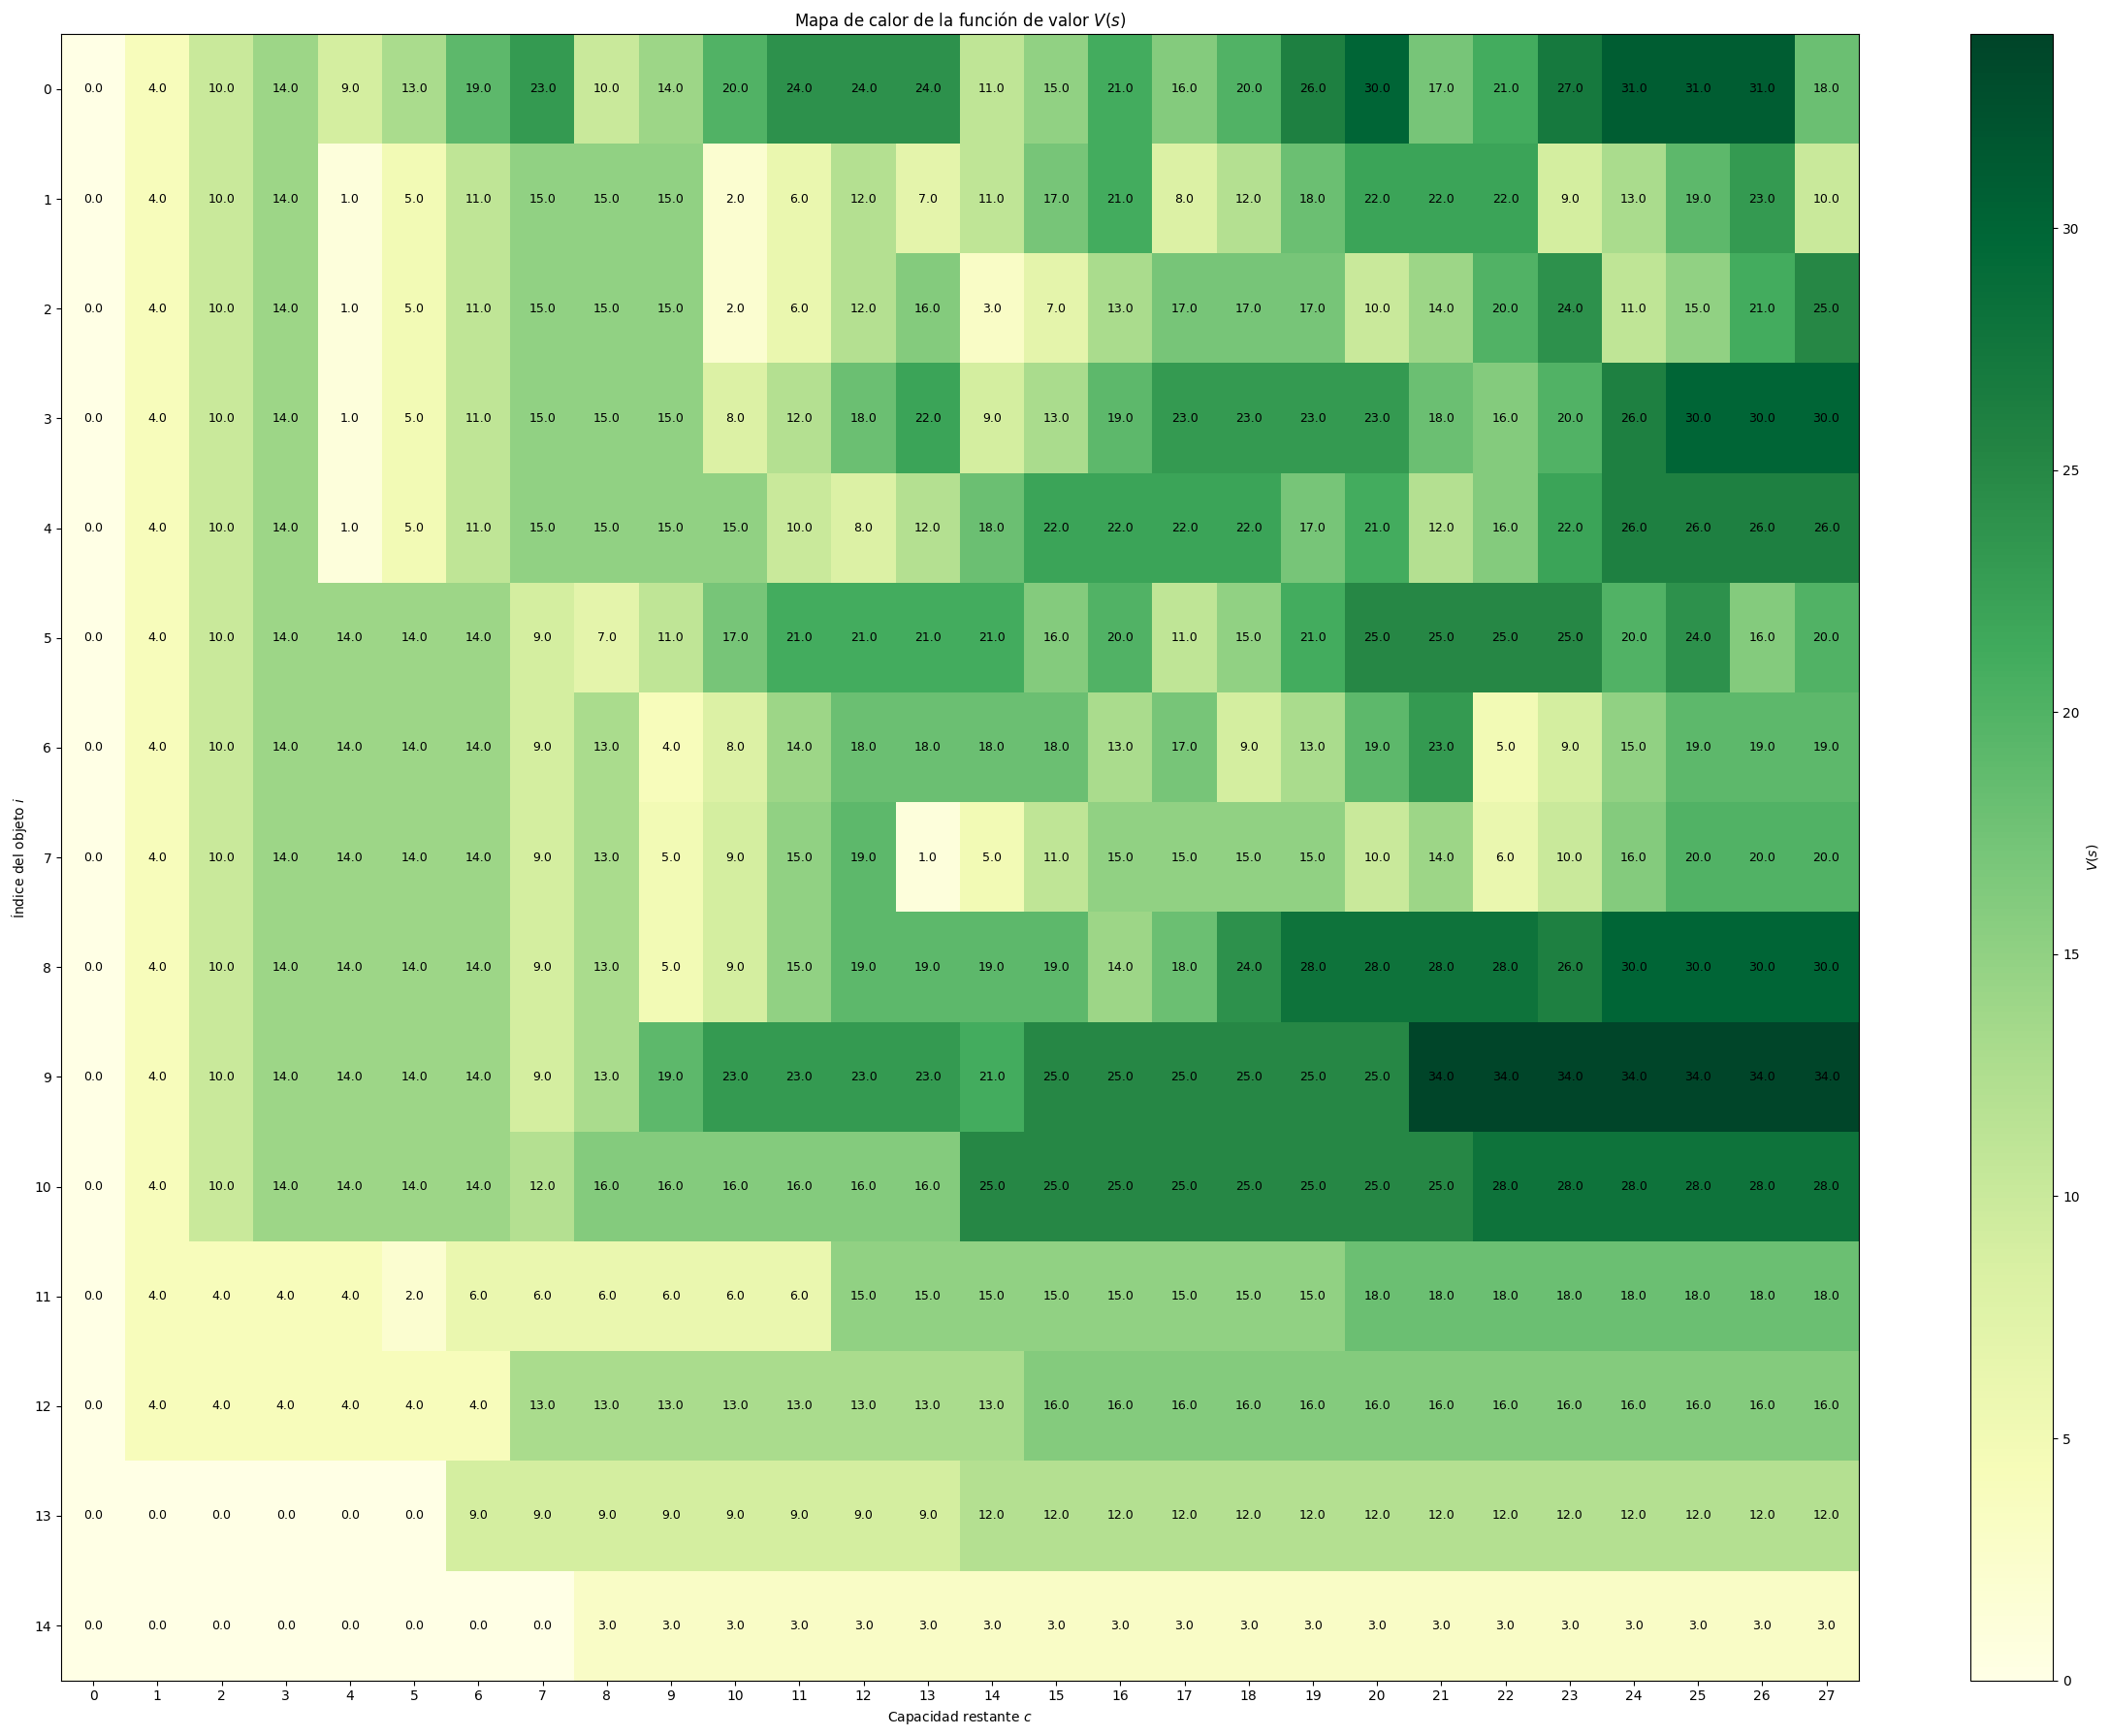


Policy Iteration


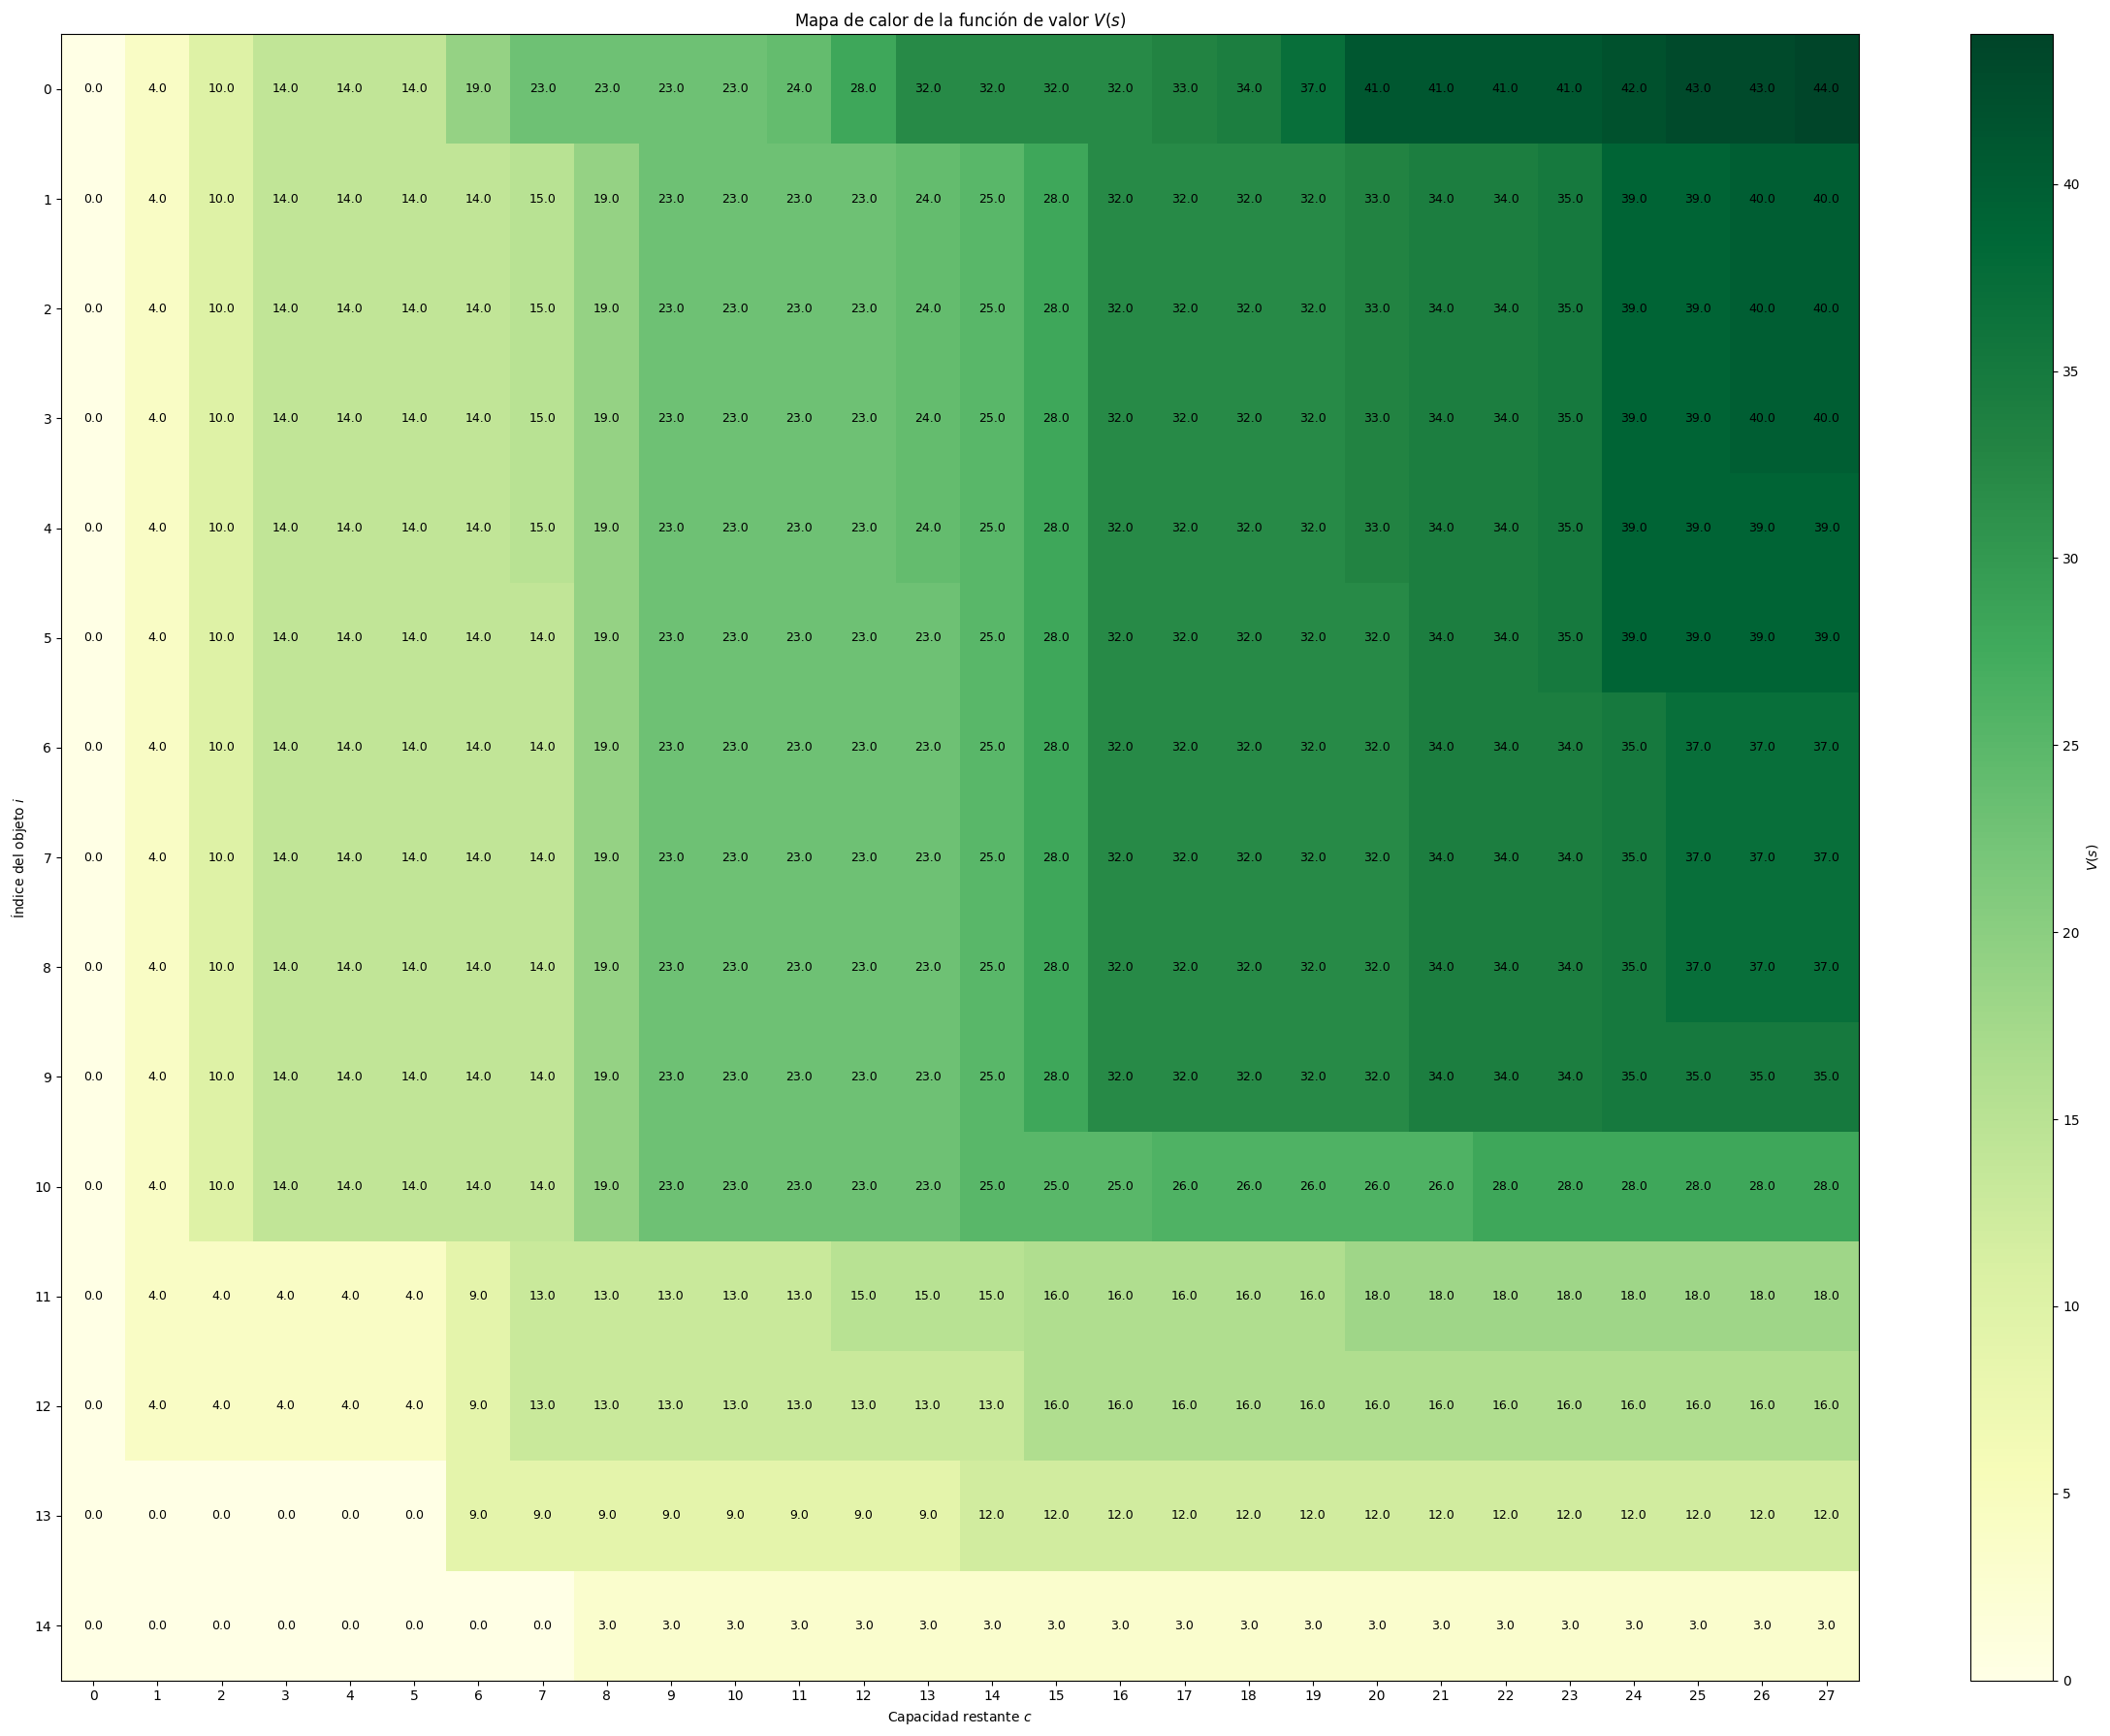


Value Iteration


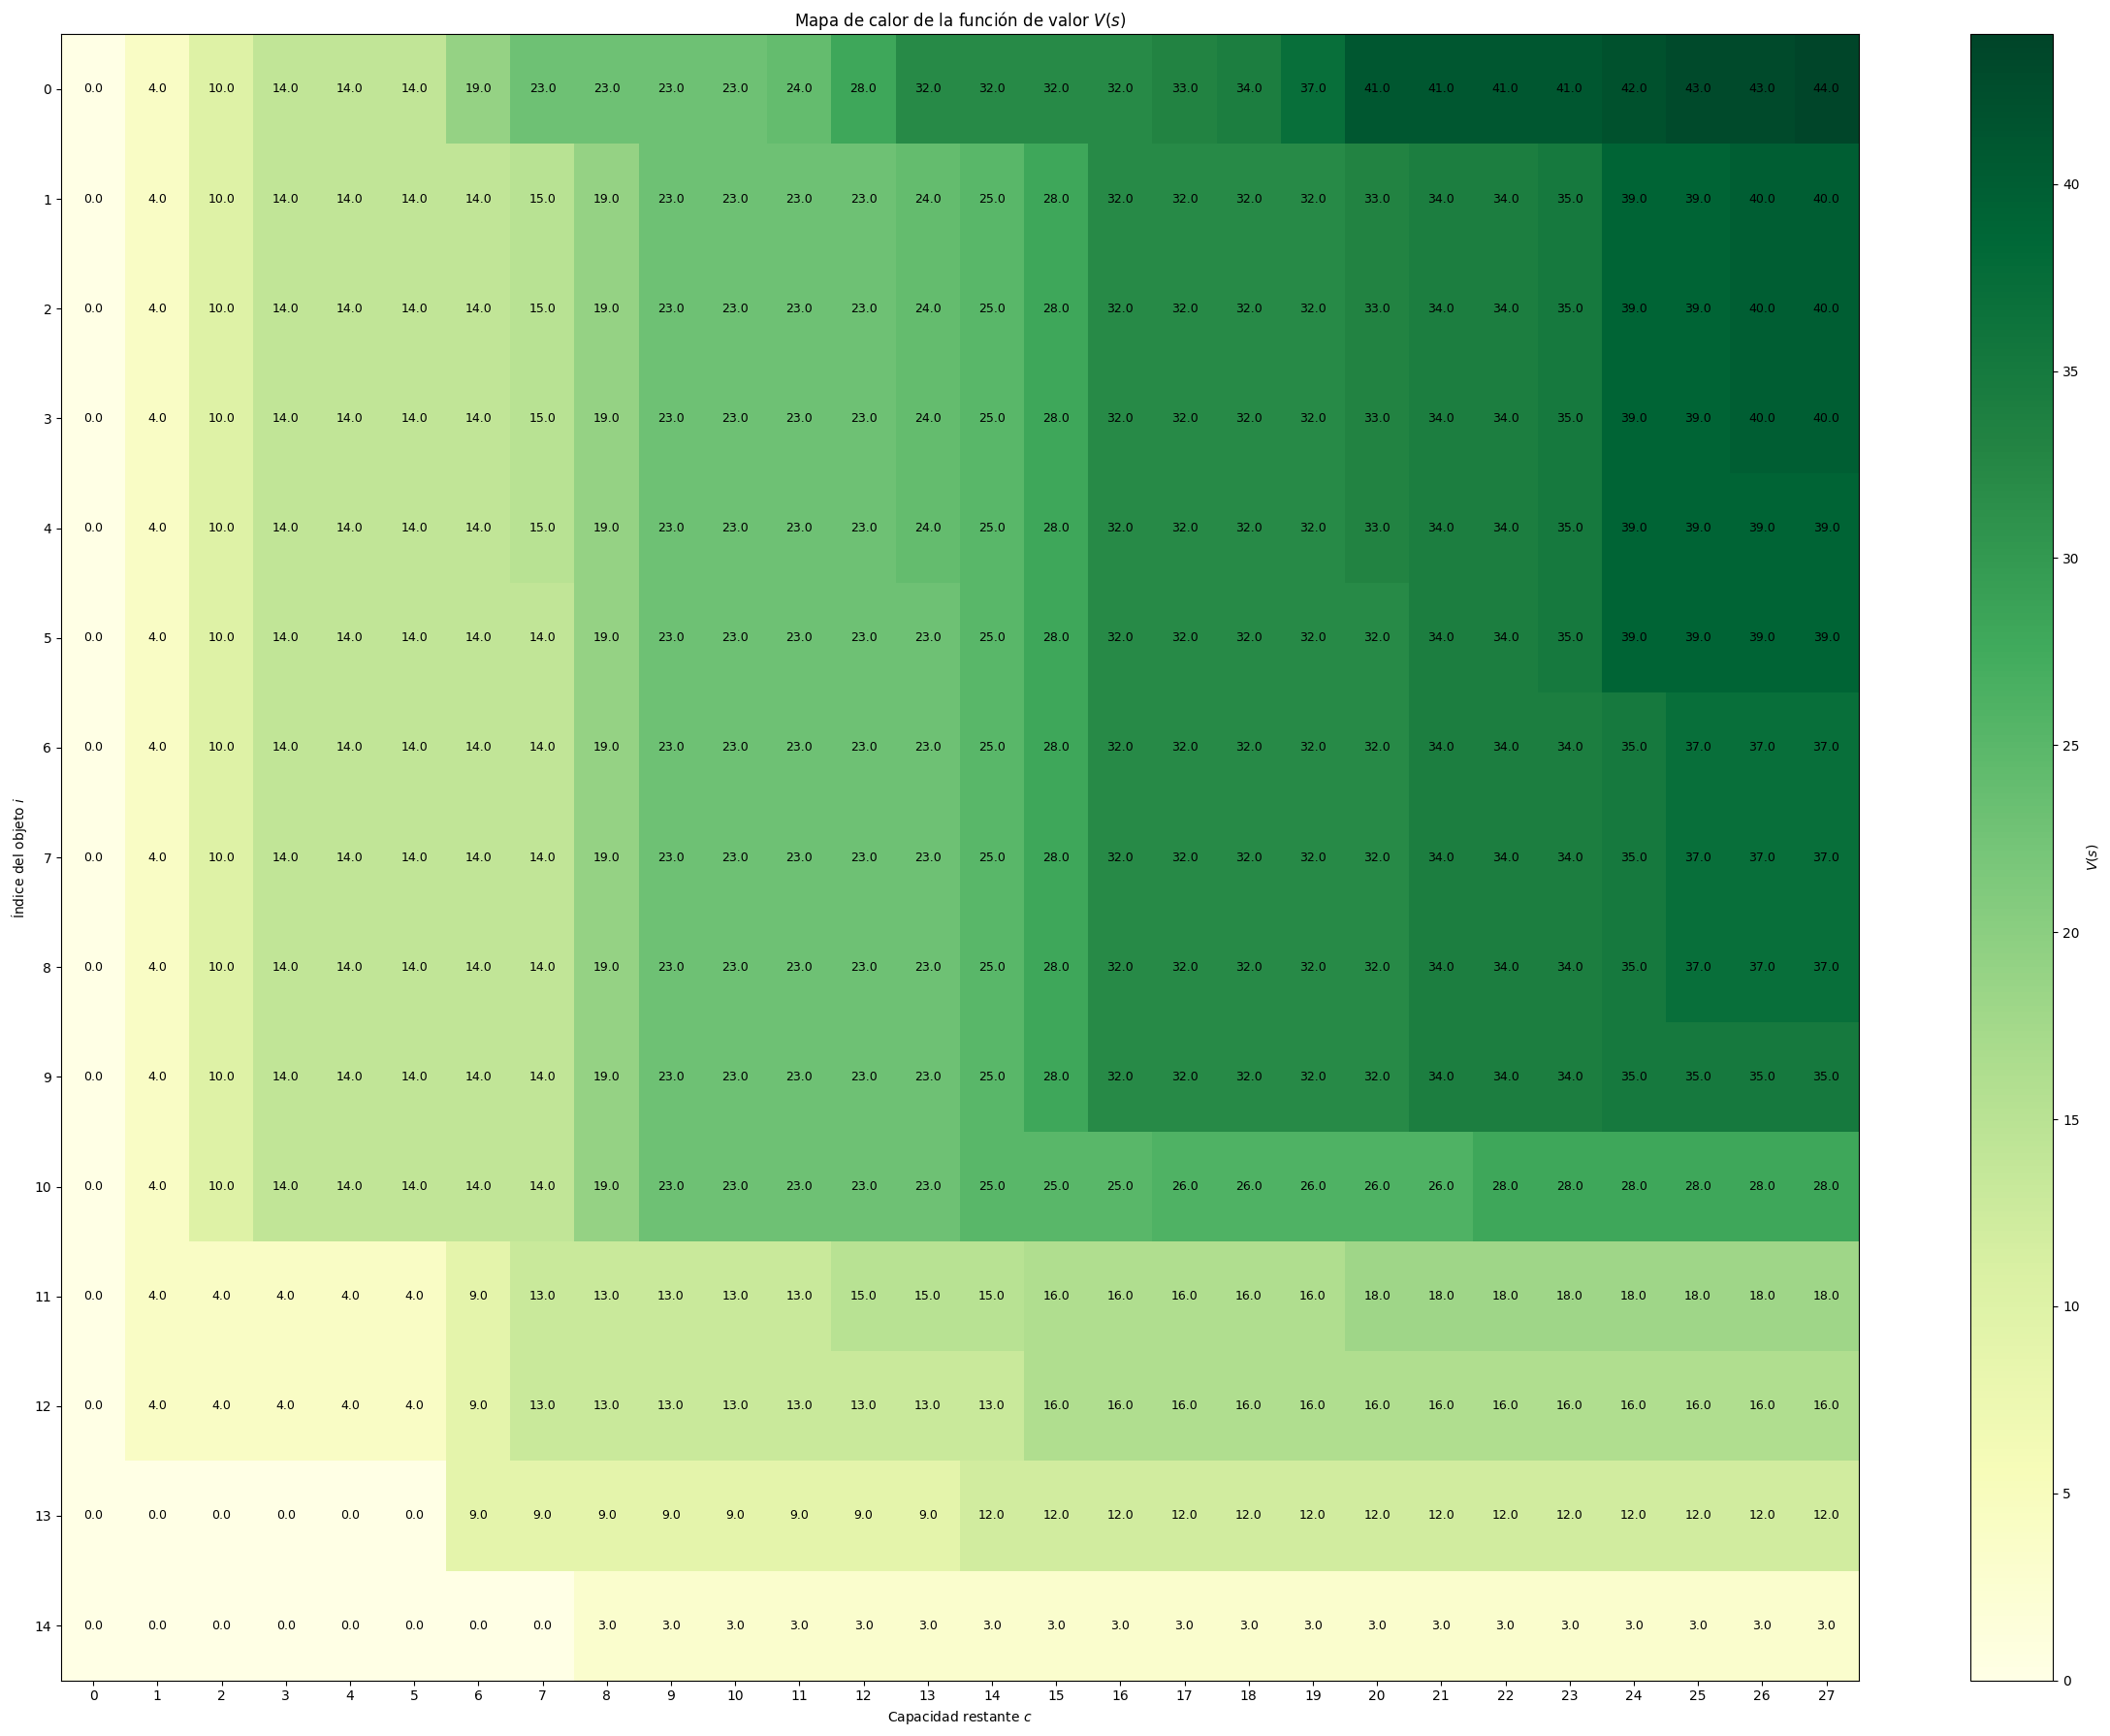

In [192]:
# Elegir entre cualquier V de las soluciones.
#       V (Policy Evaluation), V_star (Policy Iteration), V_opt (Value Iteration)

if env.n <= 20:

    print("Policy Evaluation")
    visualizar(env, V)
    print()

    print("Policy Iteration")
    visualizar(env, V_star)
    print()

    print("Value Iteration")
    visualizar(env, V_opt)
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")

### Policy

In [193]:
import networkx as nx

def draw_policy_dag(env, policy, capacity, *, pastel=True, node_size=350):
    """
    Dibuja el DAG de estados del problema de la mochila y colorea la
    trayectoria dictada por `policy`.

    Parámetros
    ----------
    env : objeto-entorno con métodos
        state_space(), actions(s), sim_step(s, a) y is_terminal(s)
    policy : dict {(i, cap): action}
        Política óptima (o la que quieras visualizar)
    capacity : int
        Capacidad inicial de la mochila (para arrancar desde (0, capacity))
    pastel : bool, opcional
        Usa colores pastel si True, de alto contraste si False
    node_size : int, opcional
        Tamaño de todos los nodos
    """

    # ----- 1) Construcción del grafo dirigido completo
    G = nx.DiGraph()
    for s in env.state_space():
        if env.is_terminal(s):
            continue
        for a in env.actions(s):
            ns, r = env.sim_step(s, a)
            G.add_edge(s, ns, action=a, reward=r)

    # ----- 2) Aristas que siguen la política
    optimal_edges = []
    state = (0, capacity)
    while not env.is_terminal(state):
        a = policy[state]
        ns, _ = env.sim_step(state, a)
        optimal_edges.append((state, ns))
        state = ns

    # ----- 3) Layout en rejilla (x = índice de objeto, y = capacidad restante)
    dx, dy = 1.6, 1.0
    pos = {(i, cap): (i * dx, (capacity - cap) * dy) for (i, cap) in G.nodes}

    # ----- 4) Mapeo colores por decisión
    palette = dict(
        pastel=dict(take="#b2e2b2", skip="#b3cde3", other="#d9d9d9"),
        vivid =dict(take="#2ca02c", skip="#1f77b4", other="#7f7f7f")
    )
    colors = palette["pastel" if pastel else "vivid"]

    decision_at = {}
    for u, v in optimal_edges:
        decision_at[u] = 1 if G.edges[(u, v)]["action"] == "take" else 0

    node_colors = [
        colors["take"]  if decision_at.get(n) == 1 else
        colors["skip"]  if decision_at.get(n) == 0 else
        colors["other"]
        for n in G.nodes
    ]

    # ----- 5) Grosor de arista
    edge_widths = [3 if e in optimal_edges else 1 for e in G.edges]

    # ----- 6) Dibujo
    plt.subplots(figsize=(24, 18))
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=node_size,
                           edgecolors="black", linewidths=0.4)
    nx.draw_networkx_edges(G, pos, width=edge_widths, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=6)
    plt.title("DAG de estados con trayectoria según la política")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


Policy Evaluation


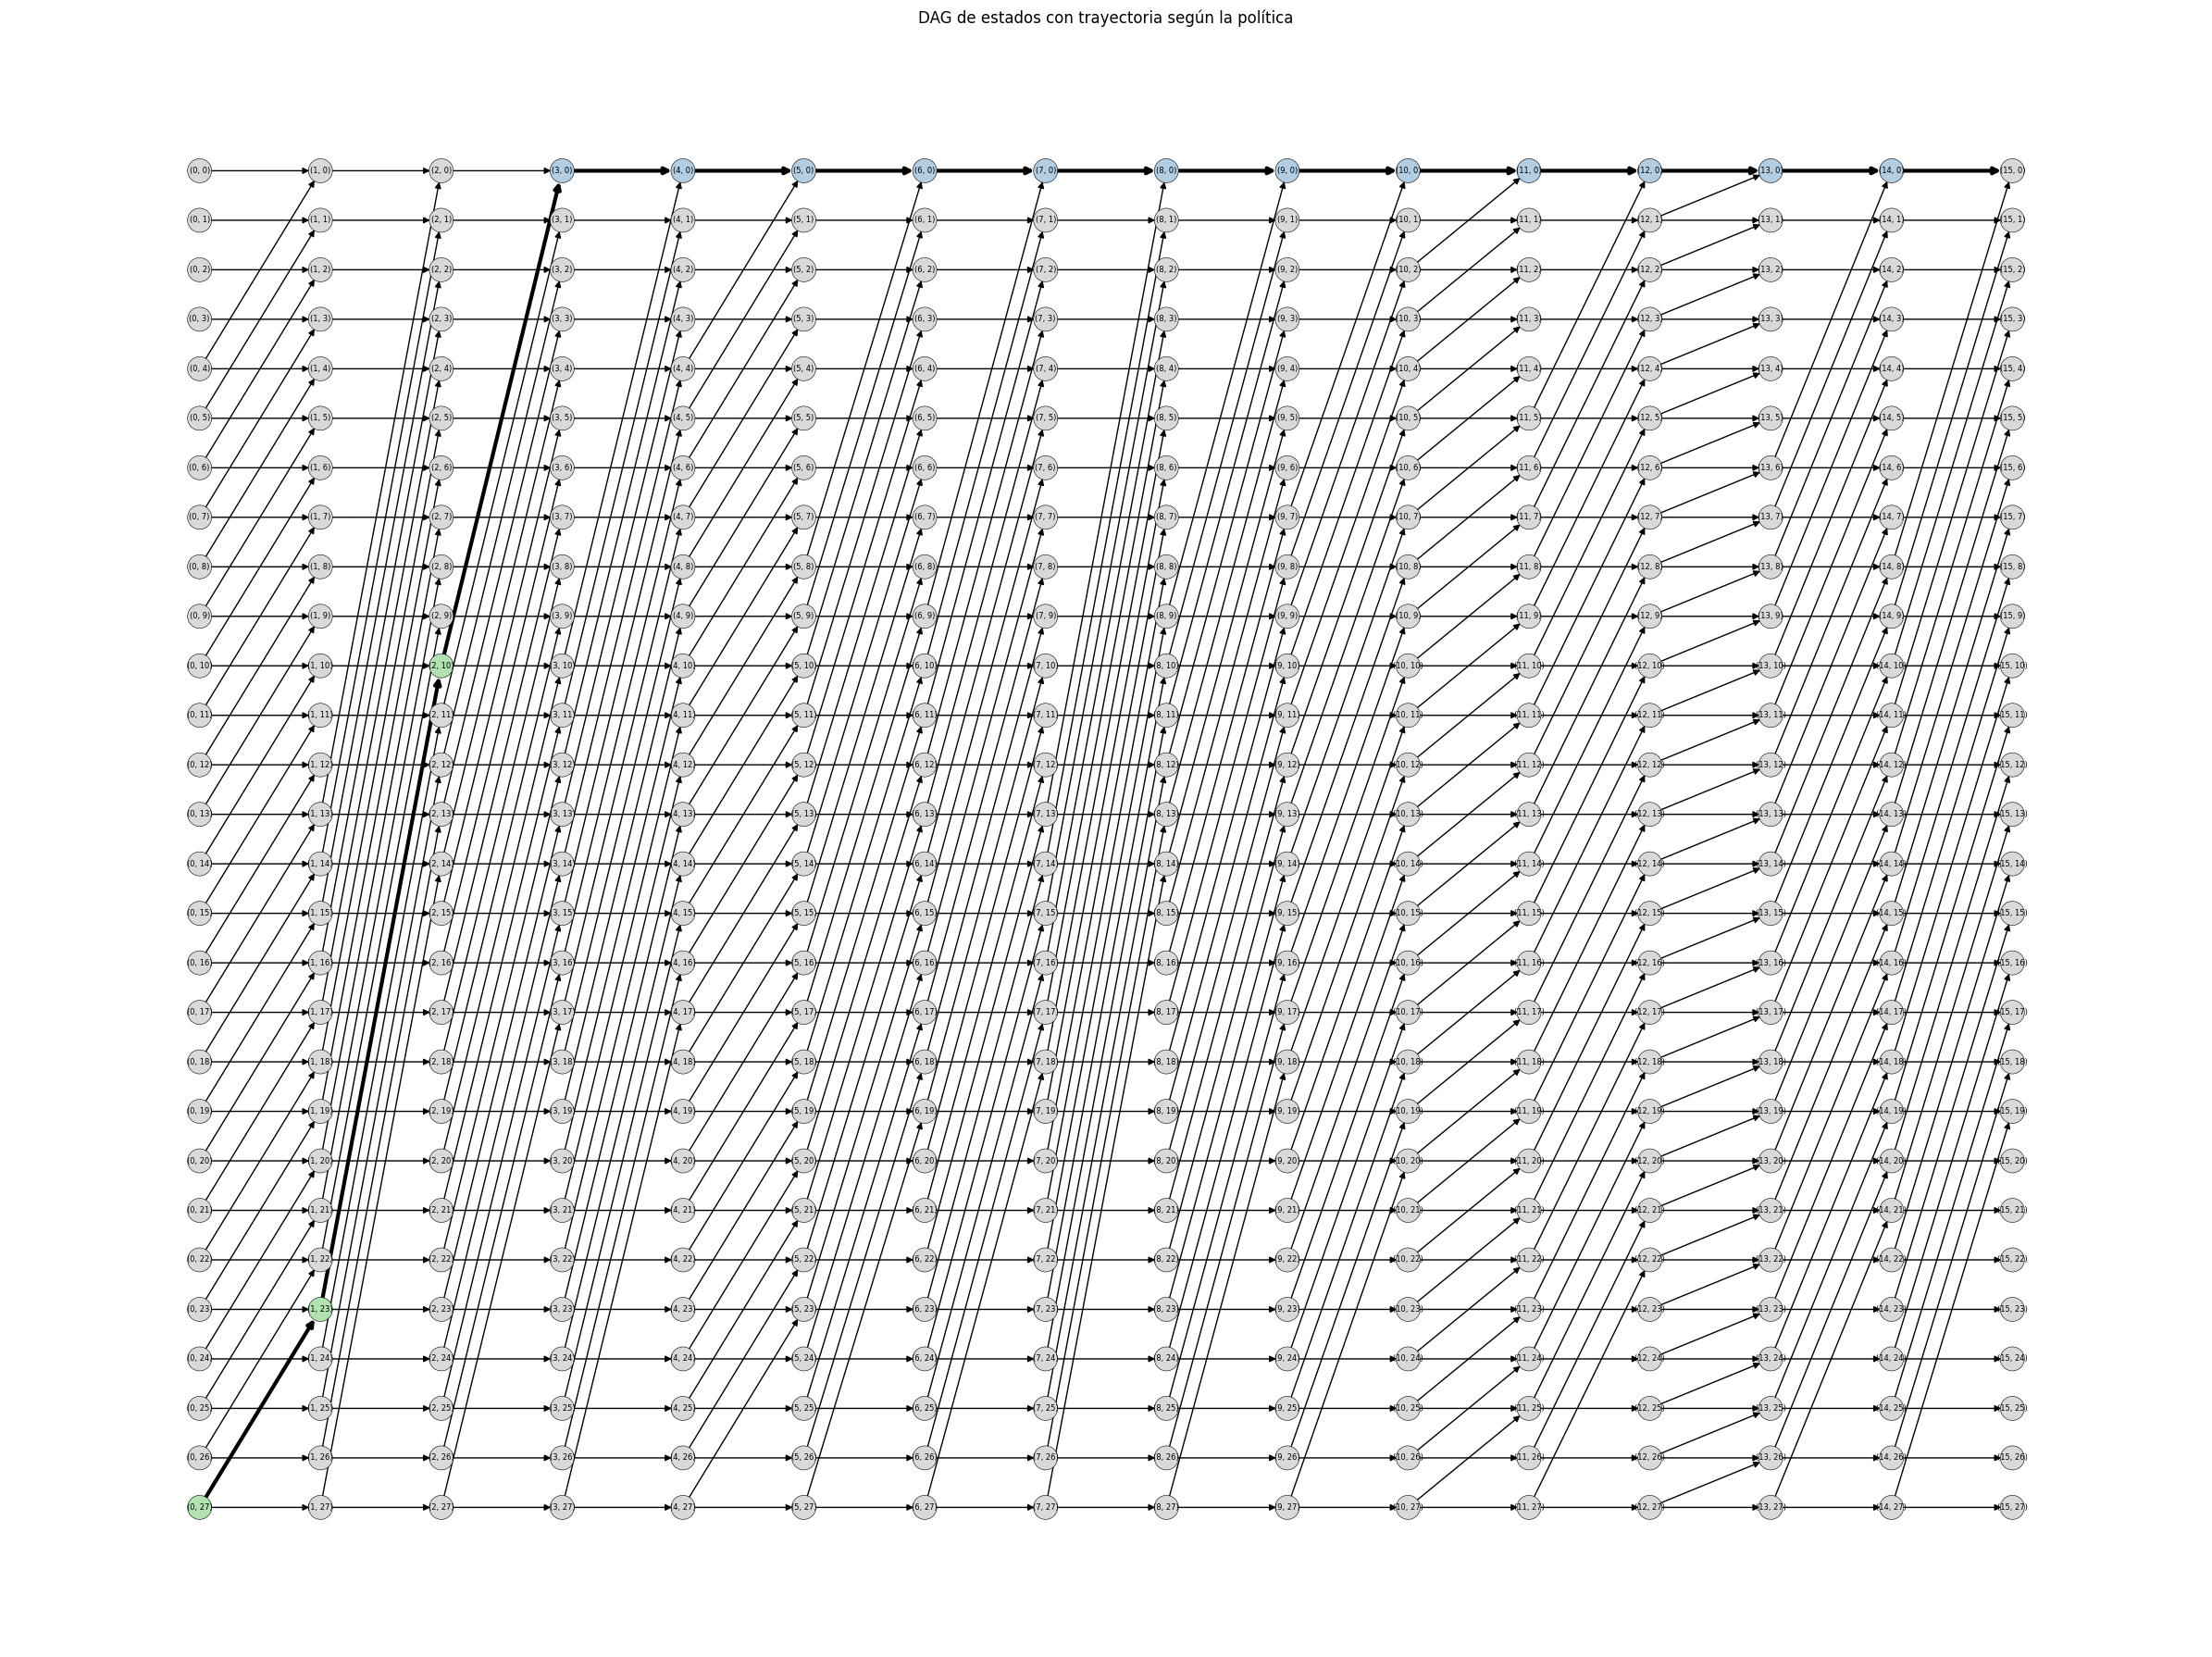


Policy Iteration


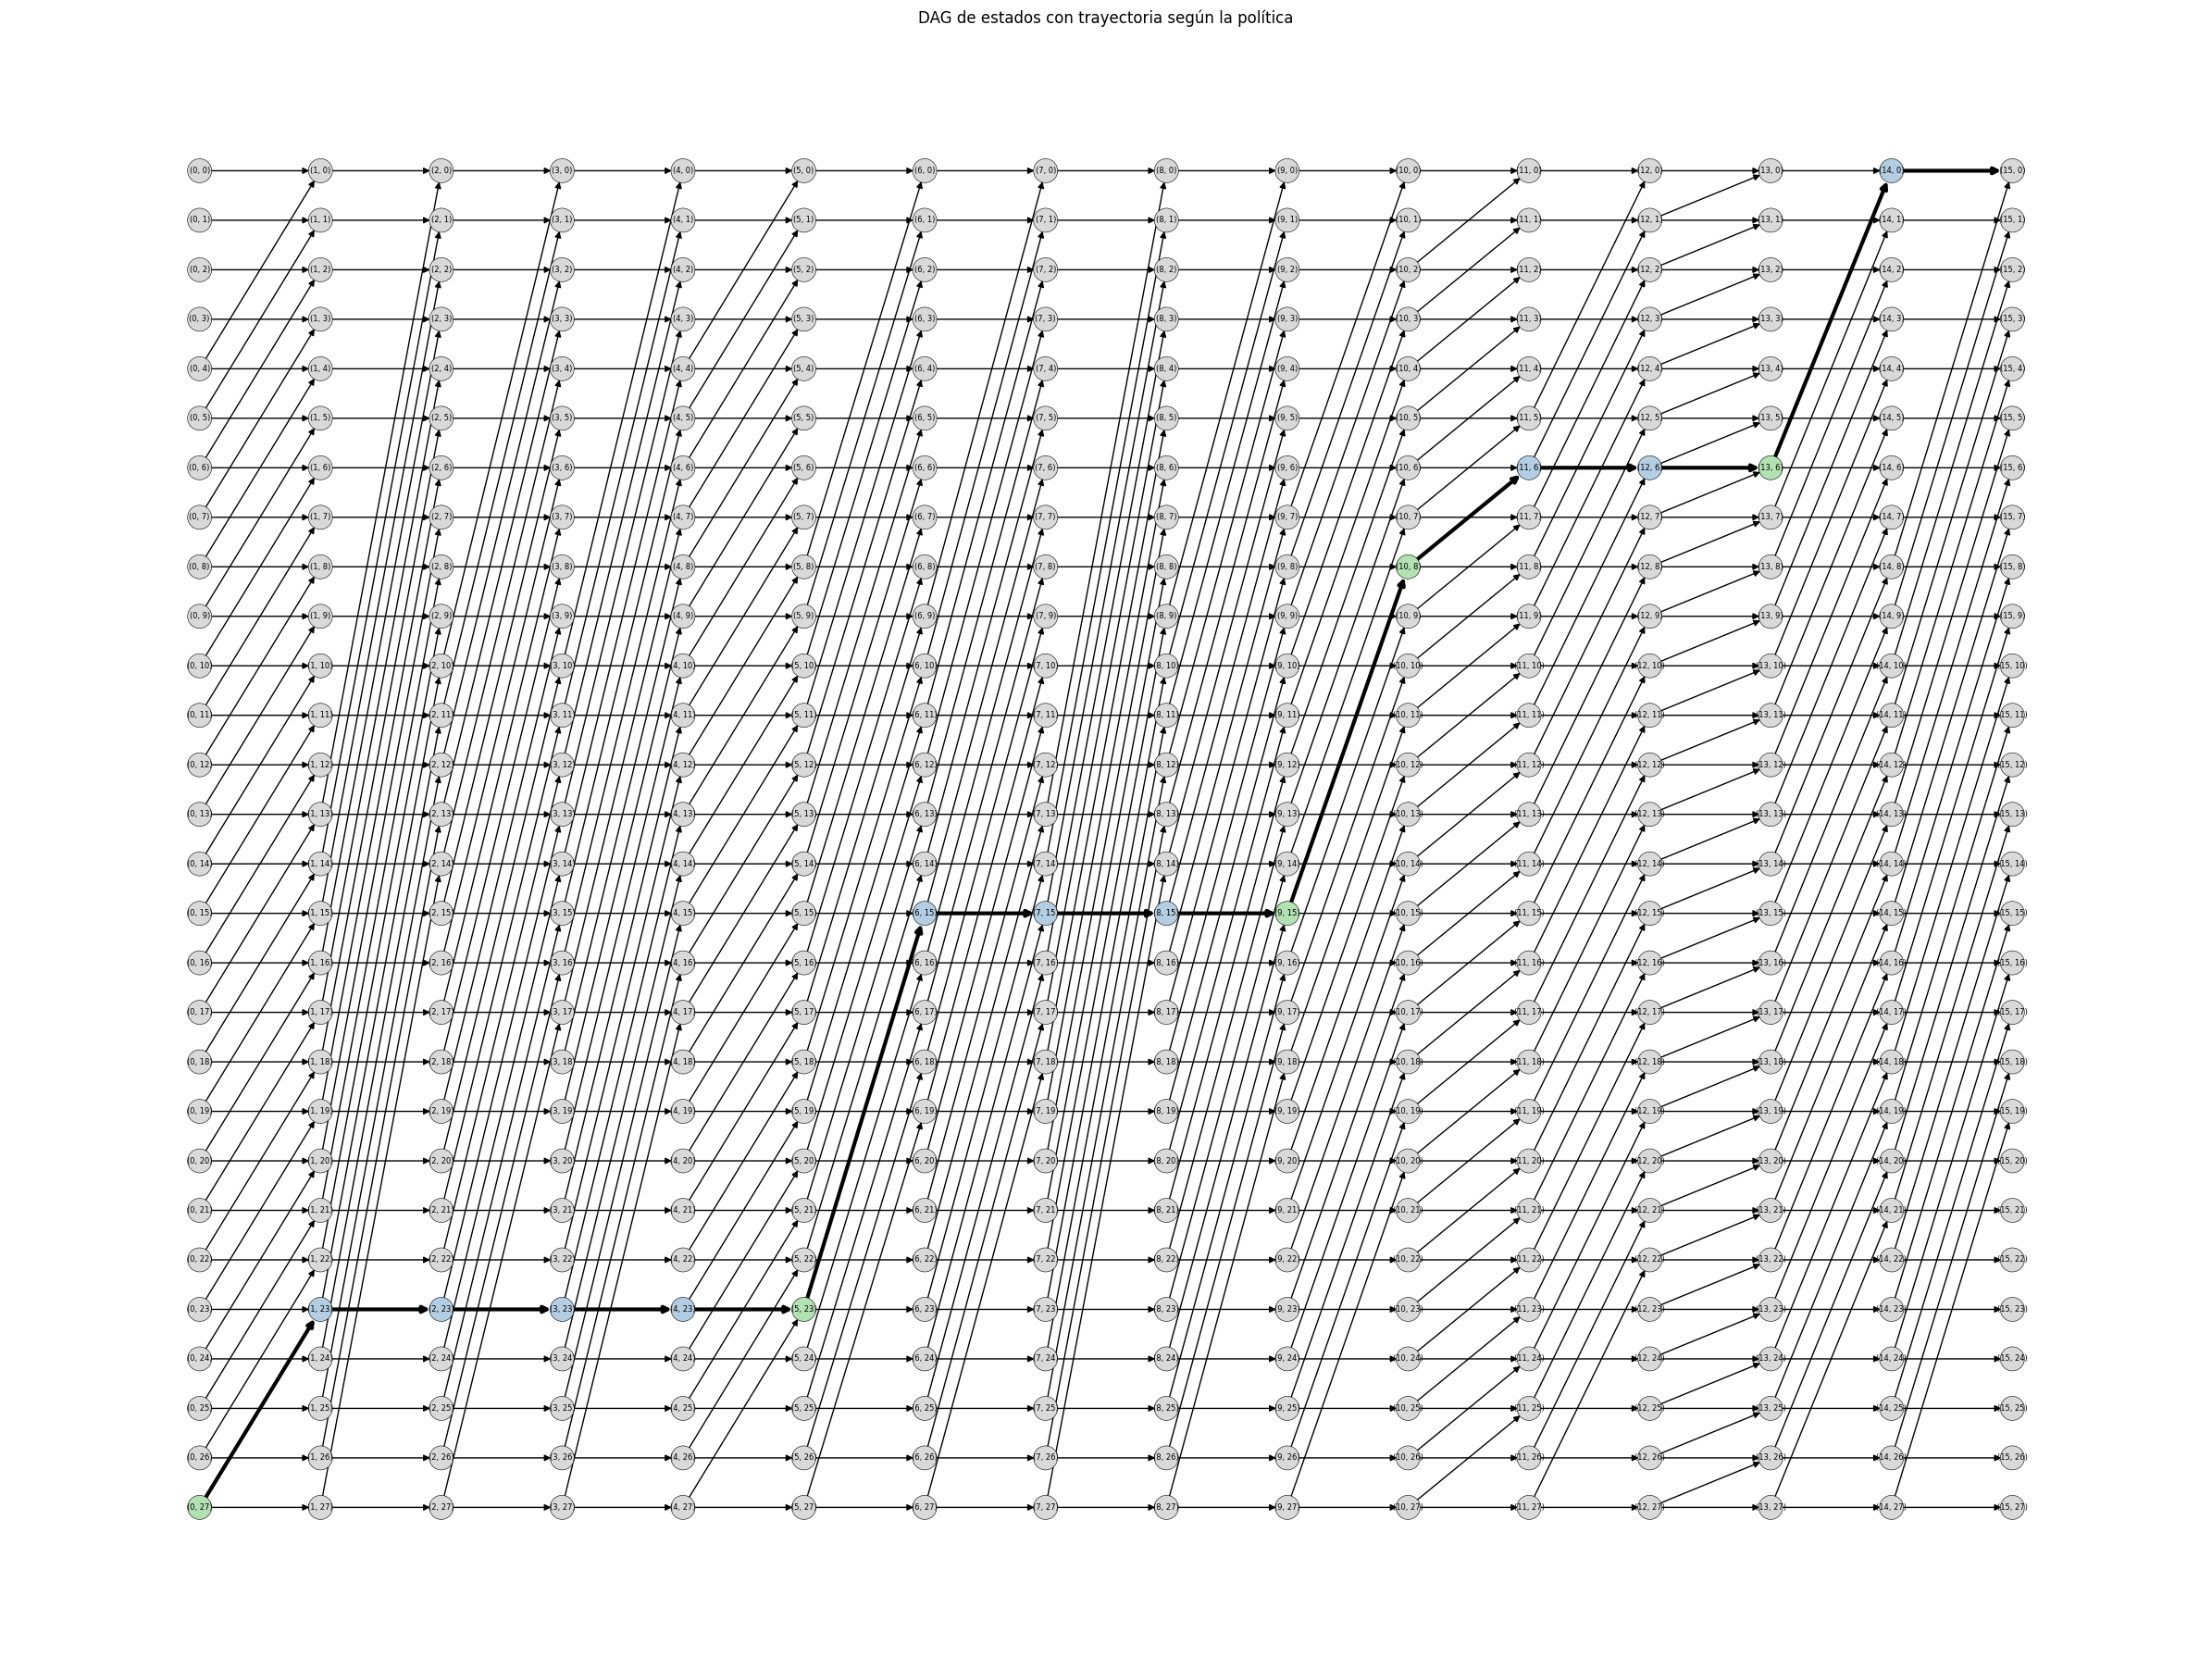


Value Iteration


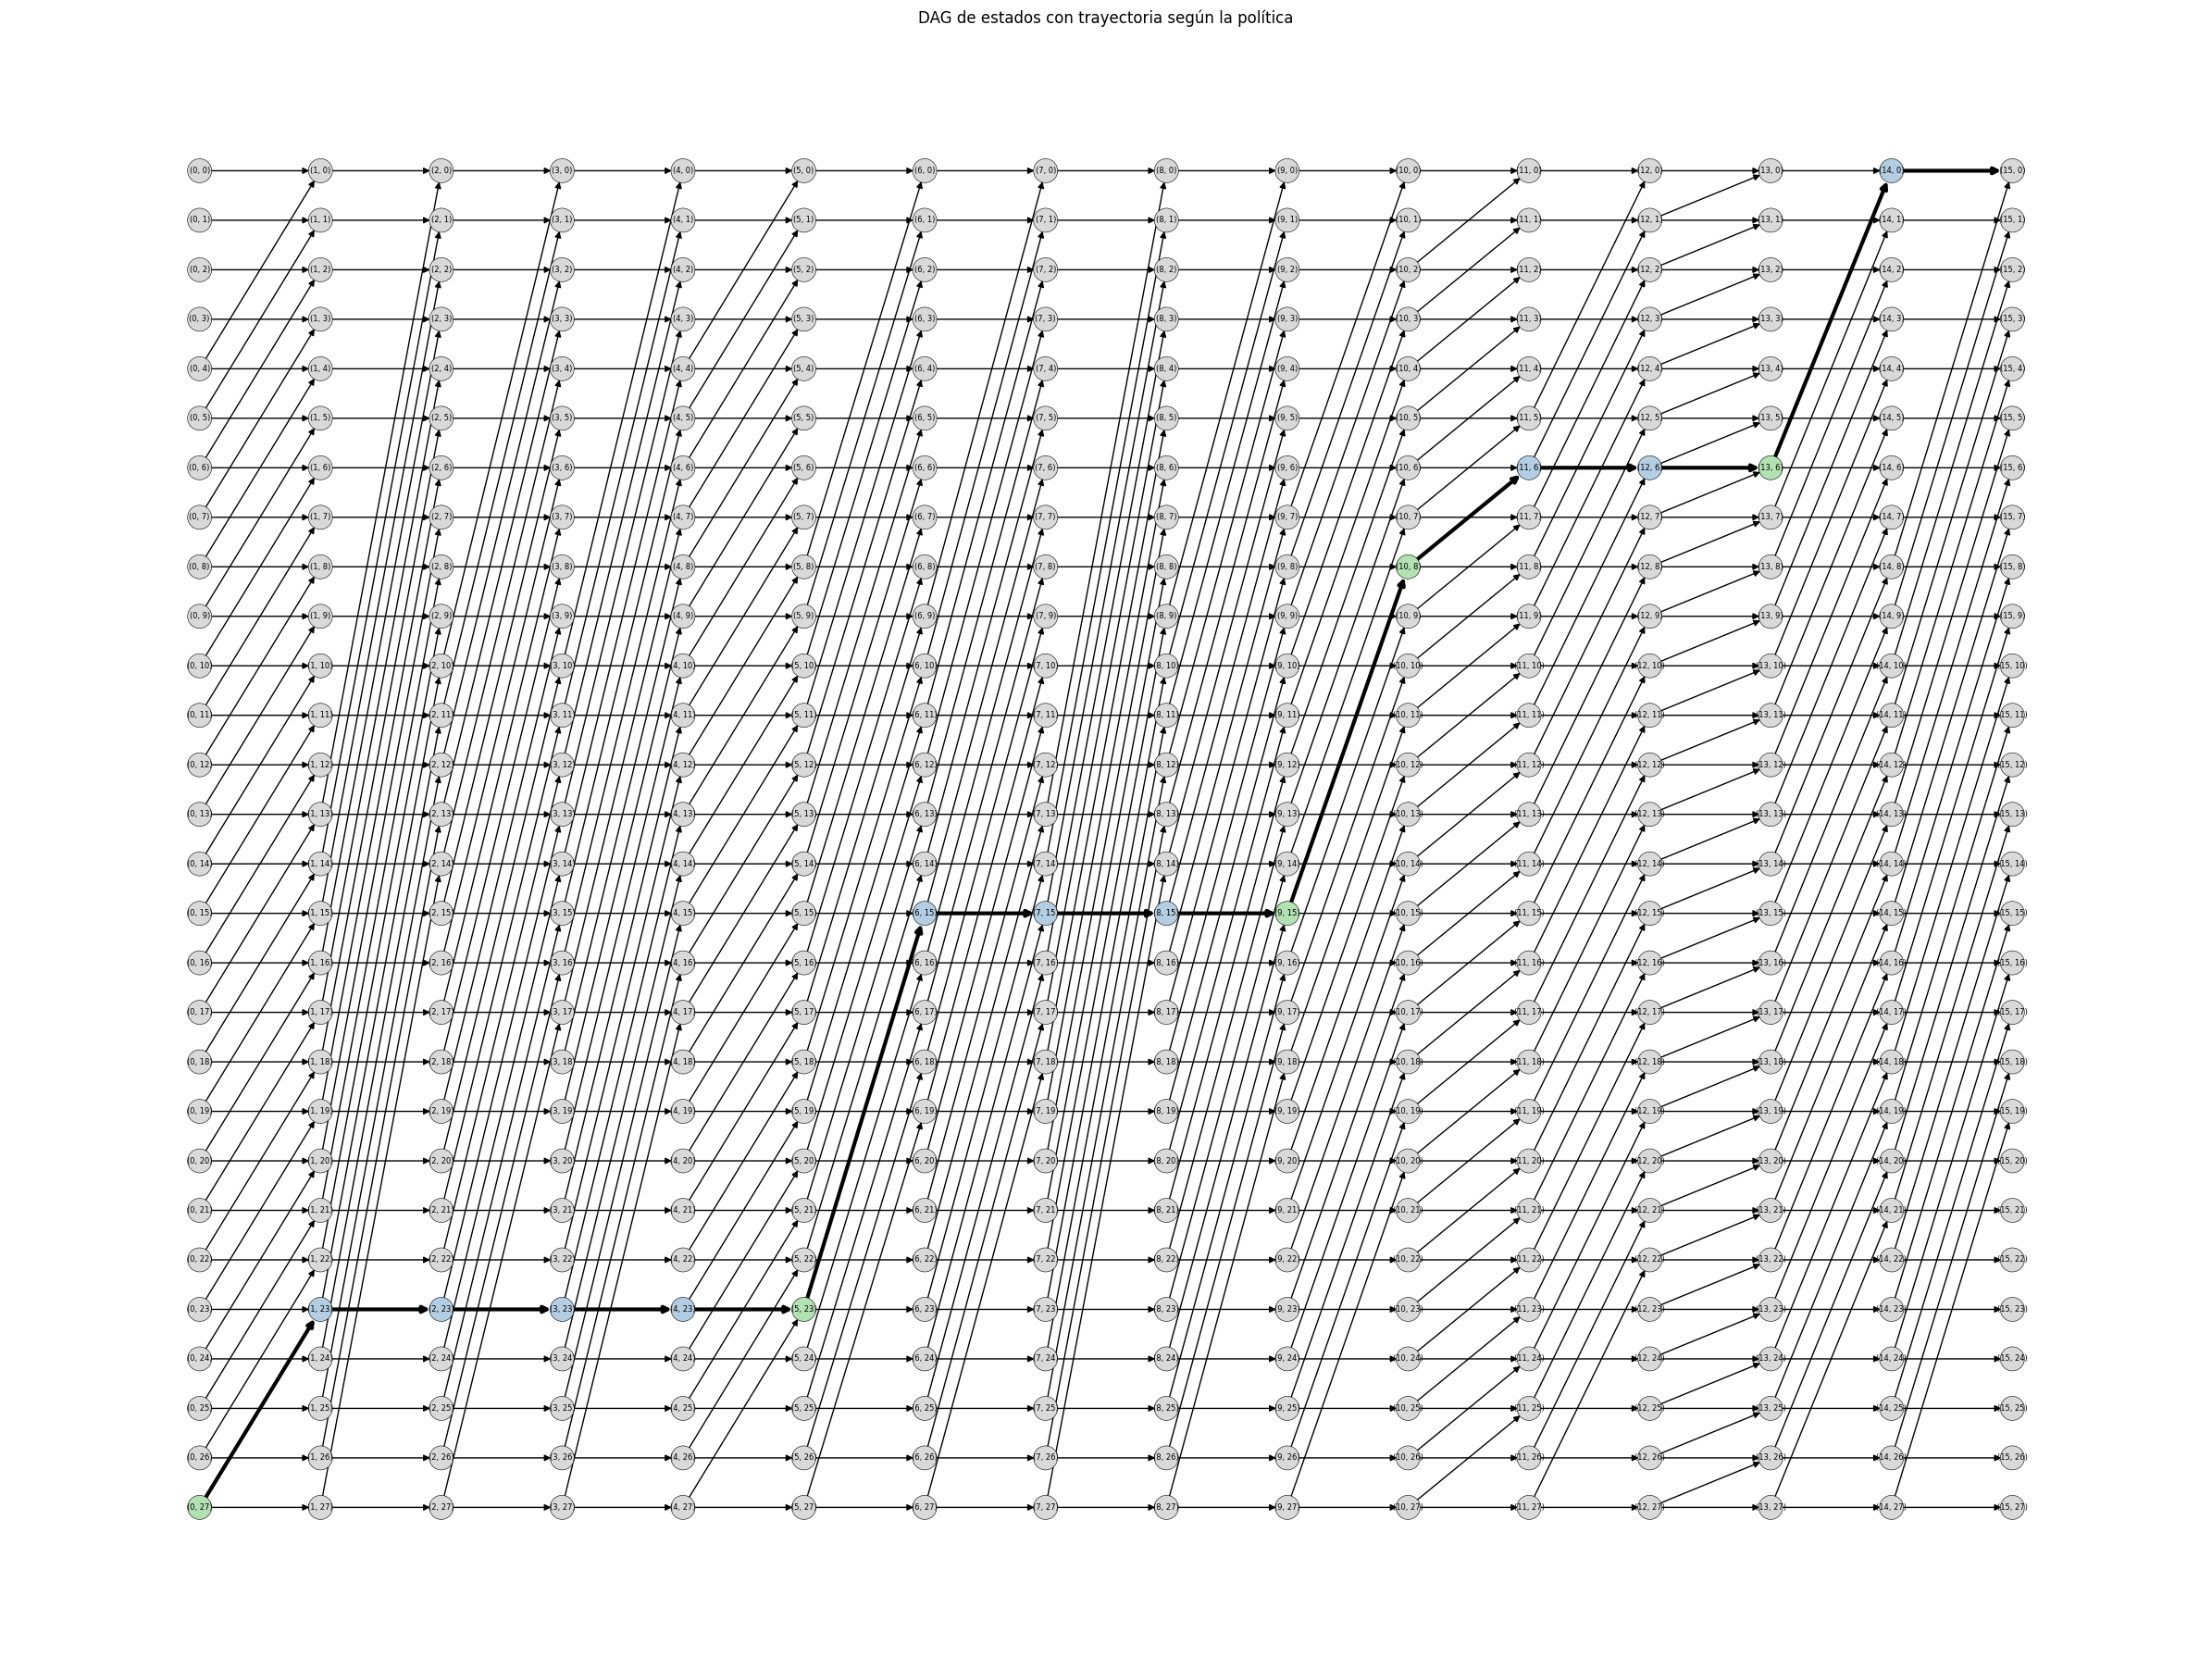

In [194]:
# Elegir entre:
#       Policy Evaluation --> eval_policy
#       Policy Iteration --> star_policy
#       Value Iteration --> opt_policy


if env.n <= 20:

    print("Policy Evaluation")
    draw_policy_dag(env, propose_policy, capacity)
    print()

    print("Policy Iteration")
    draw_policy_dag(env, star_policy, capacity)
    print()

    print("Value Iteration")
    draw_policy_dag(env, opt_policy, capacity)
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")